# Week 9: Residual networks

## General instructions

Each week you will be given an assignment related to the associated module. You have roughly one week to complete and submit each of them. There are 3 weekly group sessions available to help you complete the assignments. Attendance is not mandatory but recommended. However, assignments are graded each week and not submitting them or submitting them after the deadline will give you no points.

**FORMAT**: Jupyter notebook **(single file, not in a zip please!)**

**DEADLINE**: Sunday 7th March, 23:59

## Introduction

The objective of this assignment is to get a better intuition as to why residual networks work in practice. More particularly, we will investigate how adding skip connections to a feeforward neural network affects its gradient when combined with carefull initialization of the weights and biases and batch normalization. In all the present work, **we will solely investigate networks' initialization, that is the statistics of sampled neural networks without any training.** We will in particular emphasize how the depth of feedforward neural networks tends to "break" the gradients, which is known to make training much more difficult. 

Observing the gradients is made difficult by the fact that a neural network typically has many variables. To tackle this problem, rather than computing the gradients with respect to the network's parameters as you are now used to, we will instead compute the gradients with respect to the input data. This is meaningful since by the chain rule, the derivatives with respect to inputs are connected to the derivatives with respect to parameters. Furthermore, we will investigate a neural network $x \mapsto f(x)$ mapping $\mathbb{R}$ to $\mathbb{R}$, making it convenient for us to investigate the one dimensional derivatives with respect to inputs. Since we are interested in observing how network depth negatively affects the structure of gradients, we will use a simple grid of uniformly spaced data points ranging from -1 to 1 as input for our network. The exact structure of the neural network is given in the image below:

![title](a_simple_NN-1.png)


Your task is to complete all the cells from the notebook (more detailed instructions are provided in each cell). **In the last cell, you will be asked to provide a thorough visualization (with plots !) and analysis of your experiments. Do not take this lightly as it will be the most important aspect for the grading.**


## Andrew's Videos related to this week's assignment

- [C4W2L03 ResNets](https://www.youtube.com/watch?v=ZILIbUvp5lk&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=14)
- [C4W2L04 Why ResNets work](https://www.youtube.com/watch?v=RYth6EbBUqM&list=PLkDaE6sCZn6Gl29AoE31iwdVwSG-KnDzF&index=15)

## Going further

- https://arxiv.org/pdf/1702.08591.pdf
- https://arxiv.org/pdf/1805.07477.pdf


# Setup

In [1]:
import math
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn  as sns
import copy

torch.backends.cudnn.benchmark = True

# Utility functions

(You will use these later !)

In [2]:
def compute_correlation(array):
    correlation = np.corrcoef(array, rowvar=False)
    autocorrelation = correlation[:,0]
    return correlation, autocorrelation

def visualize_white_noise(num_vars, num_samples, figsize, color):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle("White noise: " + "$w_n \\sim \\mathcal{N}(0,\\sigma)\\quad \\forall n$")
    white_noise = np.random.randn(num_samples, num_vars)
    correlation, autocorrelation = compute_correlation(white_noise)
    axes[0].plot(np.arange(num_vars), white_noise.mean(axis=0), color=color)
    axes[1].plot(np.arange(num_vars), autocorrelation, color=color)
    sns.heatmap(correlation, cbar=True, xticklabels=False, yticklabels=False, ax=axes[2])
    axes[0].set_title("Mean")
    axes[1].set_title("Autocorrelation function")
    axes[2].set_title("Correlation matrix")
    axes[0].set_xlabel("n", fontsize="x-large")
    axes[1].set_xlabel("k", fontsize="x-large")
    axes[0].set_ylabel("$E(w_n)$", fontsize="x-large")
    axes[1].set_ylabel("$\\rho_w(0,0+k)$", fontsize="x-large")
    plt.show()


def visualize_gradients(gradients, mean, figsize, color, name, depth):
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle("Gradients " + name + " depth " + str(depth+1))
    correlation, autocorrelation = compute_correlation(gradients)
    axes[0].plot(np.arange(gradients.shape[0]), mean, color=color)
    axes[1].plot(np.arange(gradients.shape[1]), autocorrelation, color=color)
    sns.heatmap(correlation, cbar=True, xticklabels=False, yticklabels=False, ax=axes[2])
    axes[0].set_title("Mean")
    axes[1].set_title("Autocorrelation function")
    axes[2].set_title("Correlation matrix")
    axes[0].set_xlabel("n", fontsize="x-large")
    axes[1].set_xlabel("k", fontsize="x-large")
    axes[0].set_ylabel("$E(w_n)$", fontsize="x-large")
    axes[1].set_ylabel("$\\rho_w(0,0+k)$", fontsize="x-large")
    plt.show()

# Gradient computation

In [3]:
def compute_gradient_wrt_input(neural_network, x):
    '''
    
    Input: 
        -neural_network: a neural network f
        -x: input data x=[x1,...,xk] (1D tensor)
        
    Output:
        -gradient: the gradient of the neural network wrt x, df/dx=[df/dx1,...,df/dxk]
        
    TODO: 
    1) Disable autograd for all the network's parameters.
    2) Enable autograd for x.
    3) Implement a forward pass followed by a backward pass on the neural network with input data x.
    4) Collect the gradient of the neural network in x.
    
    Note: We do not want to update the parameters of the neural network, thus we don't need an optimizer.
    
    '''
    for p in neural_network.parameters():
        p.requires_grad = False
    x.requires_grad = True
    out = neural_network(x).sum()
    out.backward()
    g = x.grad.view(1, -1)
    return g

# Residual neural network

In [4]:
class residual1D(nn.Module):
    '''
    
    TODO:
    1) Construct a feedforward neural network consisting of d layers such that:
        -Each layer is exactly "linear->batch_norm1d->ReLU".
        -Layer 0 has in_features=1, out_features=n.
        -Layers 1 to d-2 have in_features=n, out_features=n.
        -Layer d-1 has in_features=n, out_features=1.
        -Each layer has its linear component initialized such that weight, bias ~ N(0,sigma²=1/in_features) 
    2) Implement the forward function of the neural network: a_{l+1} = layer_l(a_l), (a_0 = x).
    3) Implement an alternative forward pass with skip connections: a_{l+1} = a_l + beta * layer_l(a_l), (a_0 = x).
    
    '''
    
    def __init__(self, d, n, beta, skip=False):
        super(residual1D, self).__init__()
        self.n_features = n
        self.beta = beta
        self.skip = skip
        self.n_layers = d
        self.first_layer = torch.nn.Linear(1, n)
        self.first_norm = torch.nn.BatchNorm1d(n)
        self.batch_norm = [torch.nn.BatchNorm1d(n)for i in range(1, d-1)]
        self.layers = [torch.nn.Linear(n, n) for i in range(1, d-1)]
        self.last_layer = torch.nn.Linear(n, 1)
        self.last_norm = torch.nn.BatchNorm1d(1)
        self.activation = torch.nn.ReLU()
        self.layers = [self.first_layer] + self.layers + [self.last_layer]
        self.batch_norm = [self.first_norm] + self.batch_norm + [self.last_norm]

        for layer in self.layers:
            layer.weight.data = torch.normal(0.0, math.sqrt(1/n), size=layer.weight.shape)
            layer.bias.data = torch.normal(0.0, math.sqrt(1/n), size=layer.bias.shape)

        
        
    def forward(self, x):
        a = x
        for i in range(self.n_layers):
            try:
                z = self.batch_norm[i](self.layers[i](a))
                a = a + self.beta * self.activation(z) if self.skip else self.activation(z)
            except RuntimeError:
                print("Expected features and layers", self.n_features, self.n_layers)
                print("Input: ", a.shape)
                print("layer: ", i)
                print(self.layers[-1], self.layers[0])
                sys.exit(1)
        out = a
        return out

# Experiment code

In [5]:
def inspect_gradients(network_type, x, depths, num_iters, seed, beta=0.25, start=1):
    '''
    
    Input:
        -network_type: type of neural network (either "feedforward" or "residual")
        -x: input data x=[x1,...,xk] (1D tensor)
        -depths: network depths to inspect
        -num_iters: number of iterations (number of random sampling of neural networks)
        -seed: self-explanatory
    
    TODO: 
    1) Seed pytorch
    2) For every depth, for every iteration:
        -Initialize a neural network of the desired type ("feedforward" or "residual") and depth.
        -Compute and store the gradient of the sampled network wrt x.
        -Stack the computed gradient vertically inside an array of shape [num_iters, X.shape[0]].
    3) For every depth:
        -Extract the mean of the gradients (with respect to the iterations).
        -Extract the correlation matrix and the autocorrelation function of the gradients.
    4) Visualize the statistics extracted in 3).
    
    Note: For 3) and 4), see Utility functions.
    
    '''
    torch.manual_seed(seed)
    skip = True if network_type == "residual" else False
    for depth in range(start, depths):
        gradients = torch.Tensor(num_iters, x.shape[0])
        means = []
        for n in range(num_iters):
            z = copy.deepcopy(x)
            model = residual1D(depth, x.shape[0], beta, skip)
            gradient = compute_gradient_wrt_input(model, z)
            gradients[n] = gradient
            mean = torch.mean(gradient)
            means.append(mean)
        visualize_gradients(gradients, means, [20, 10], "orange", network_type, depth)
        visualize_white_noise(num_iters, x.shape[0], [20, 10], "blue")


# Experiments and analysis

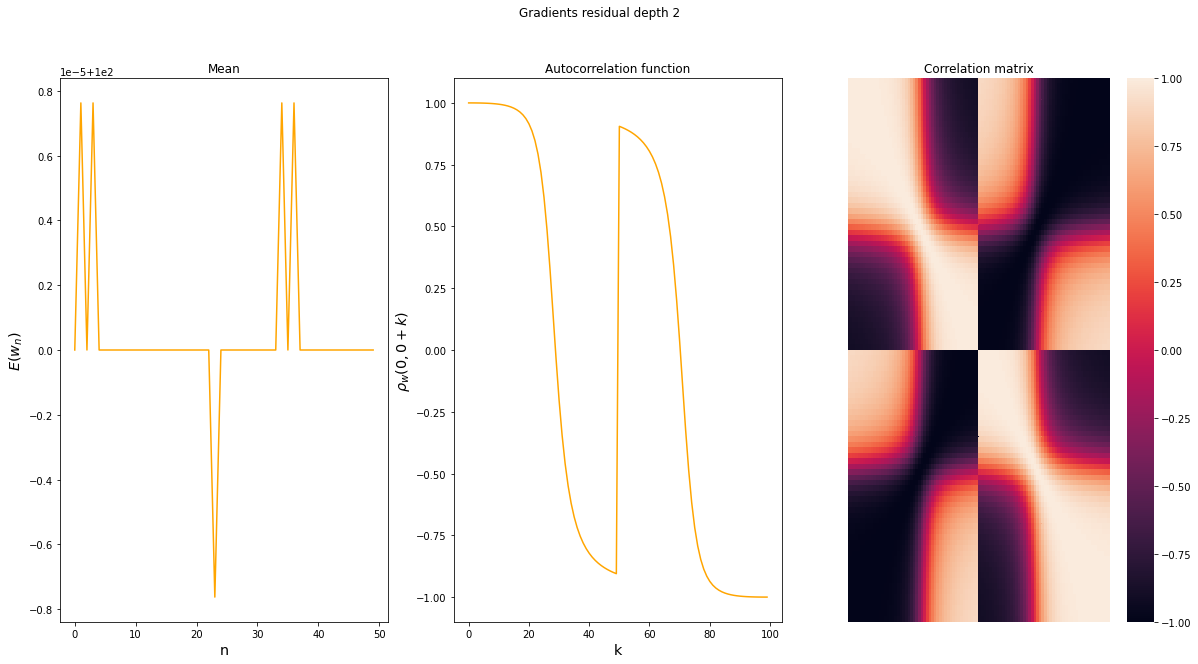

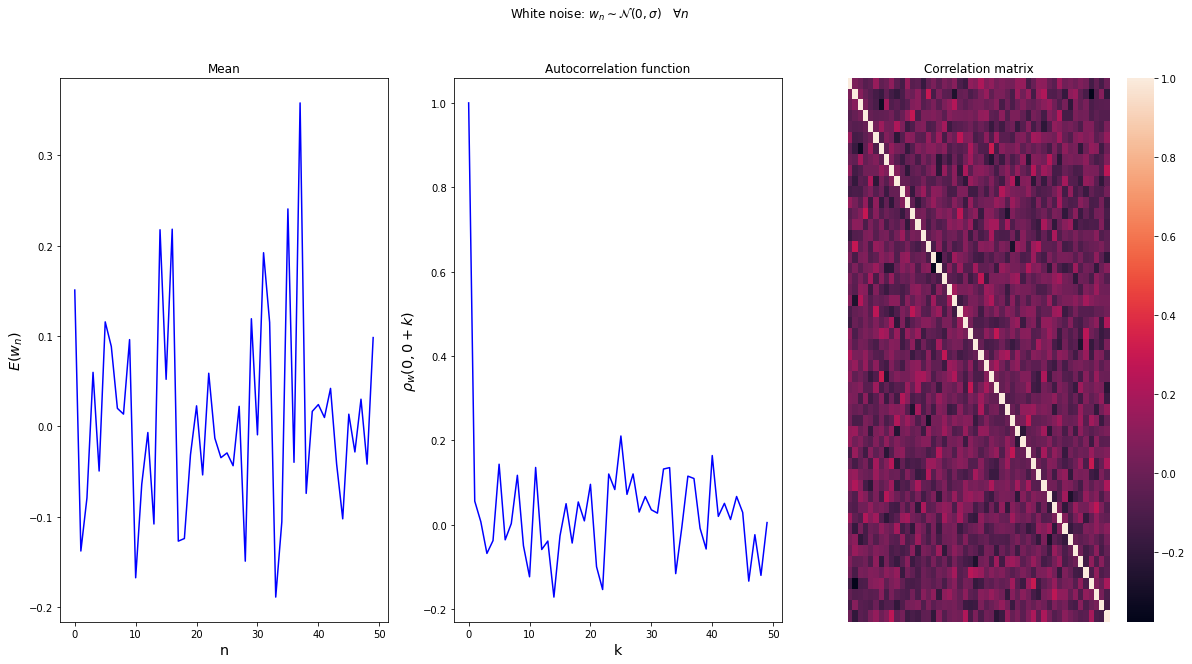

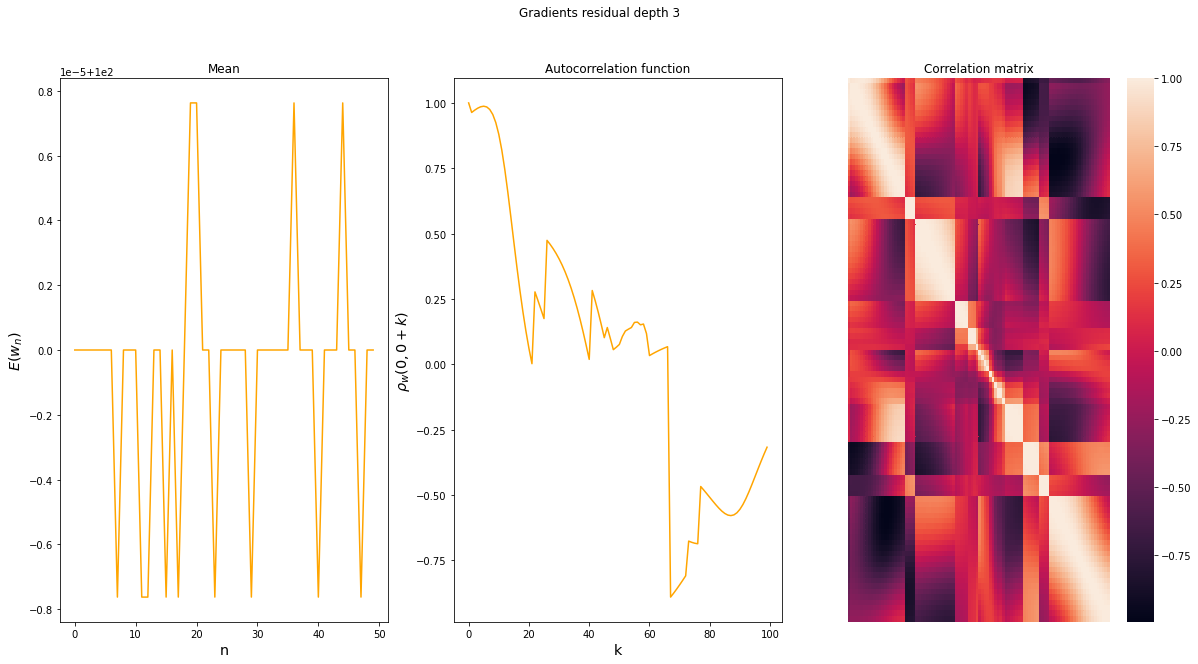

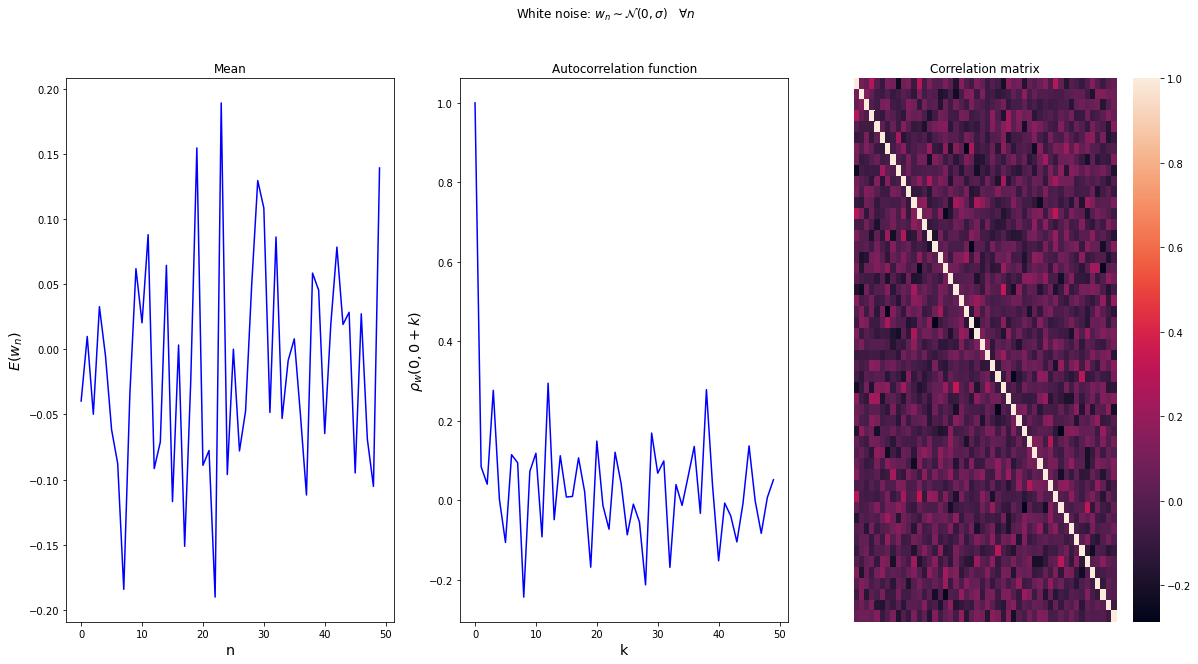

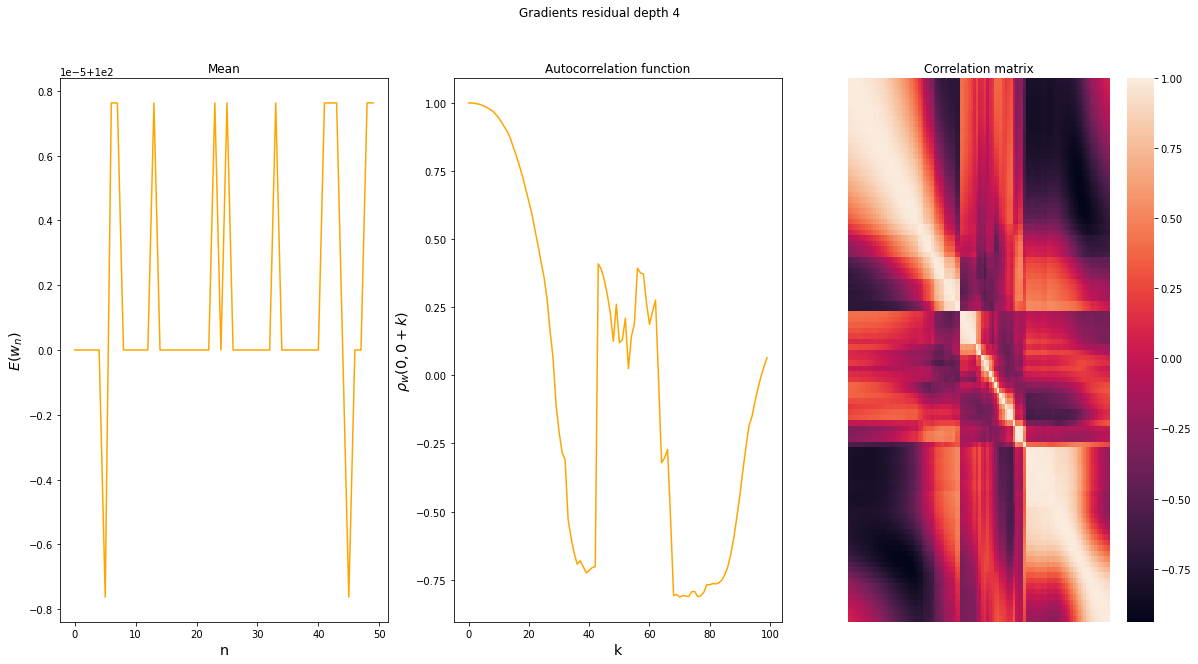

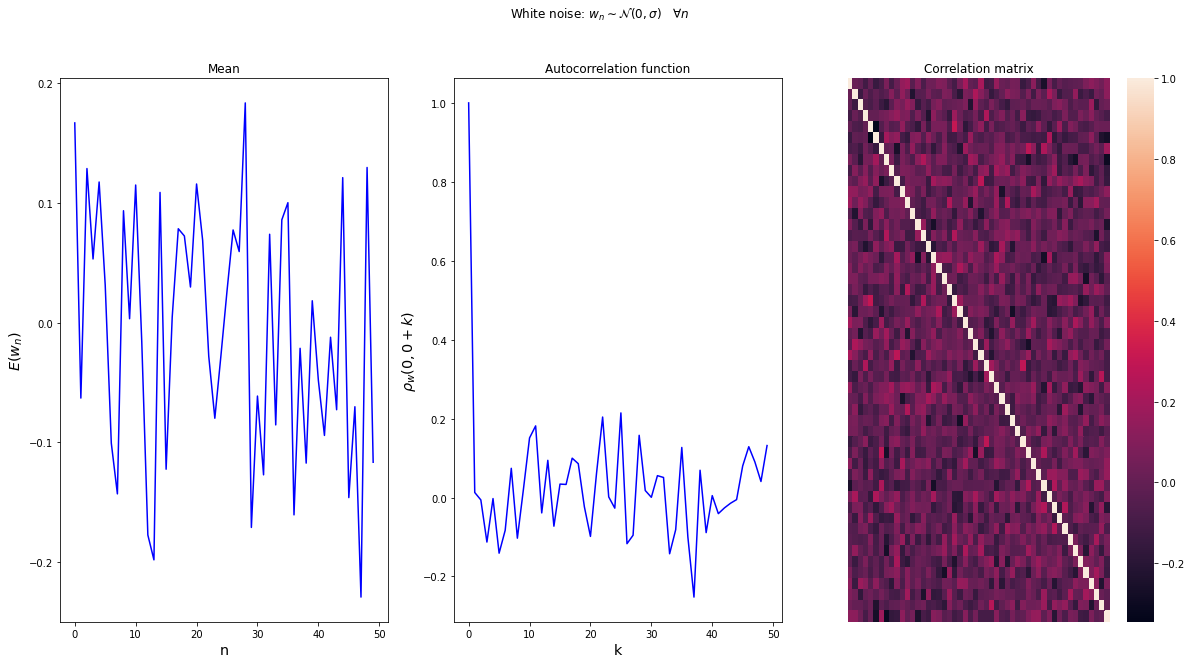

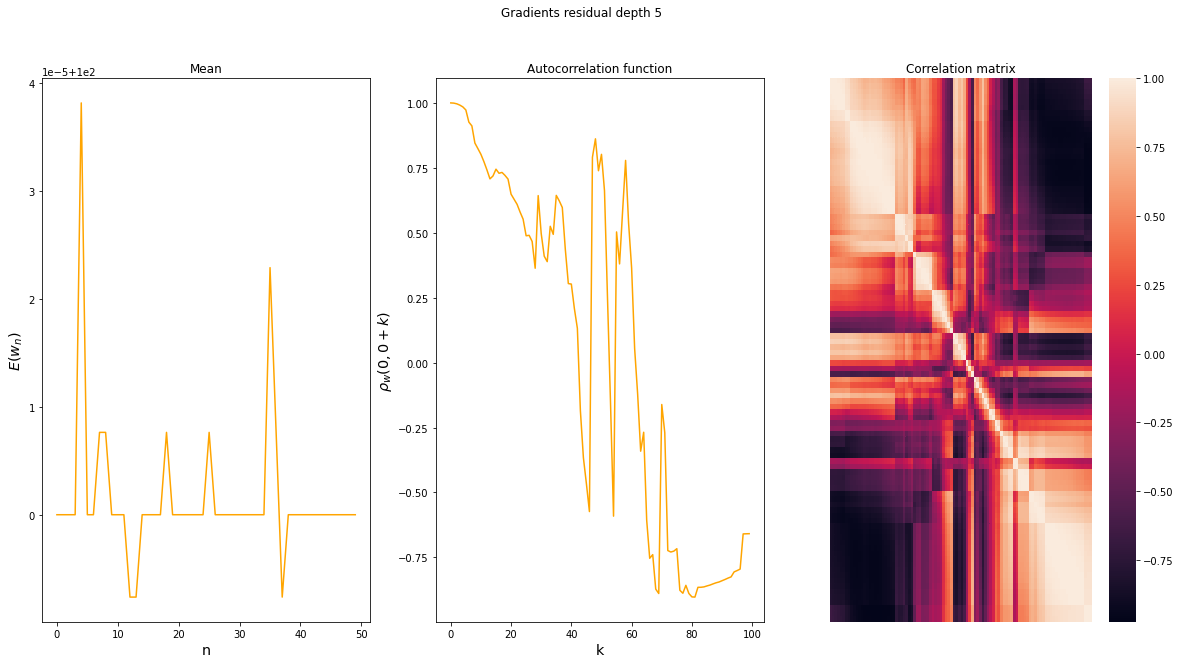

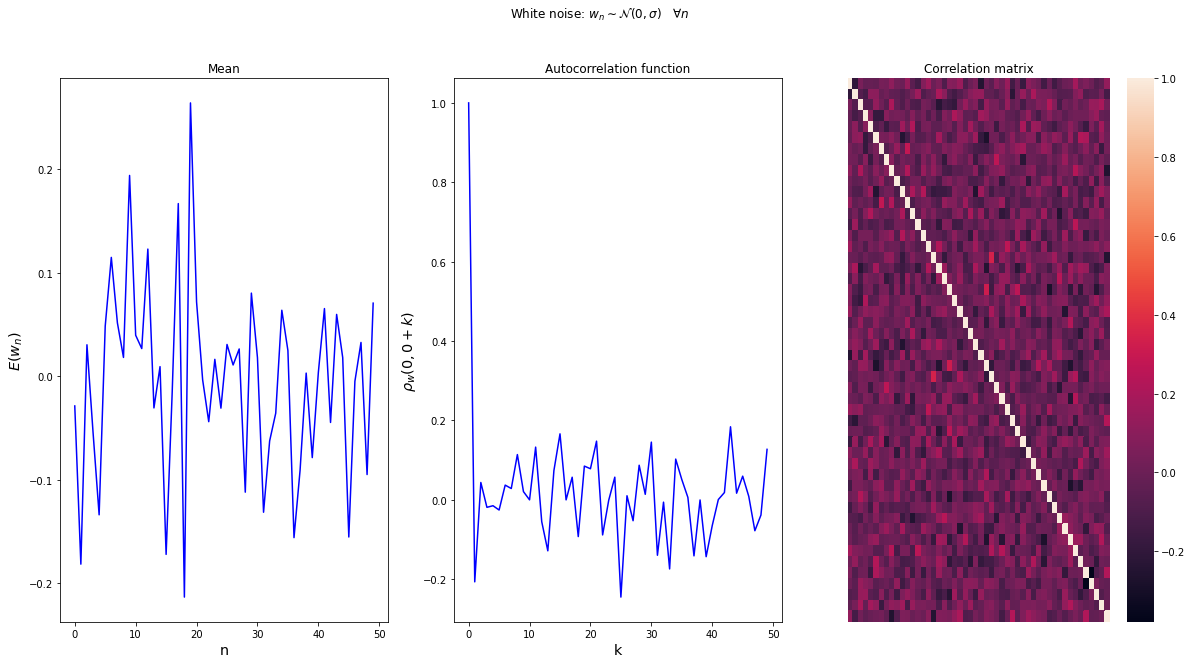

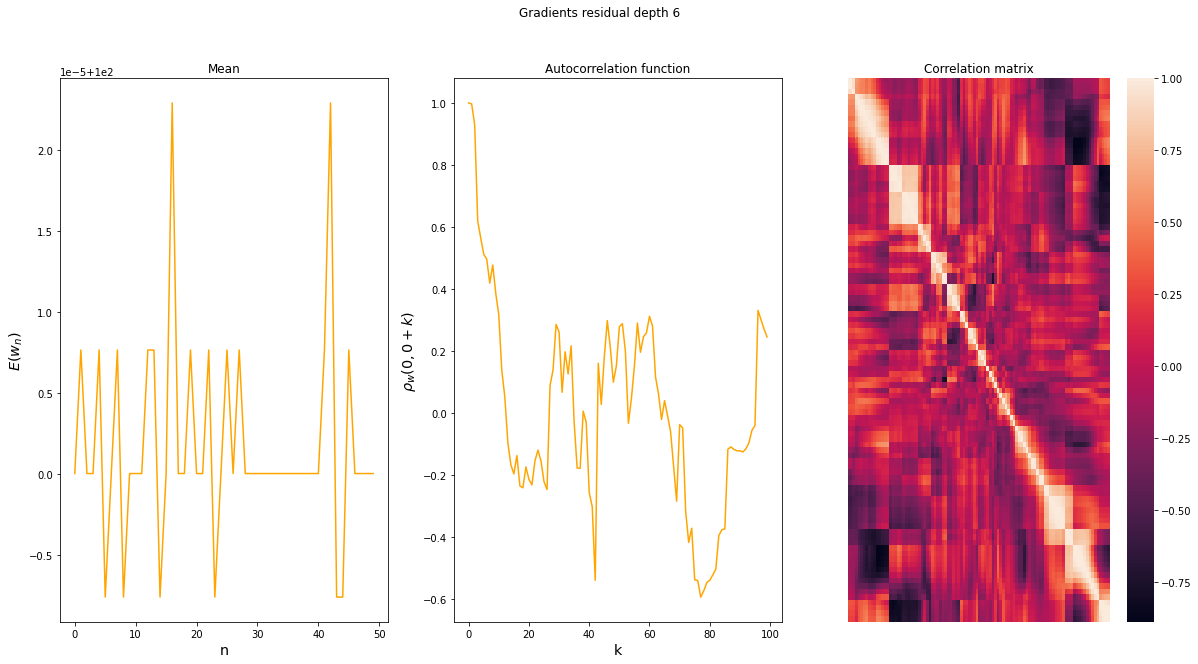

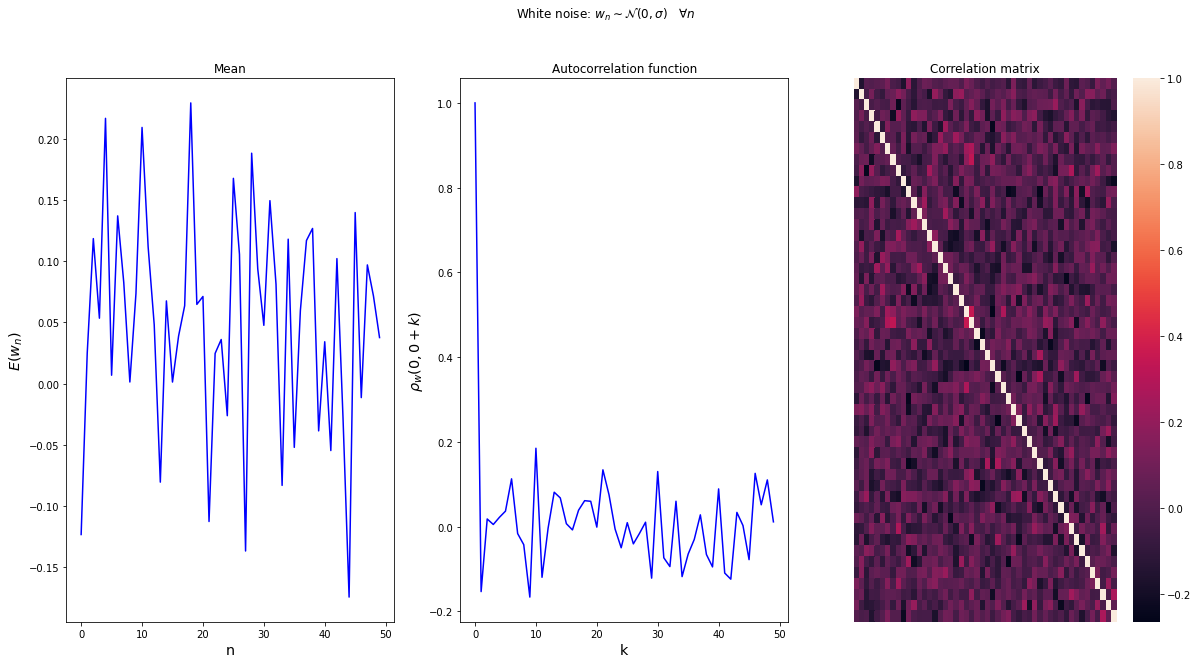

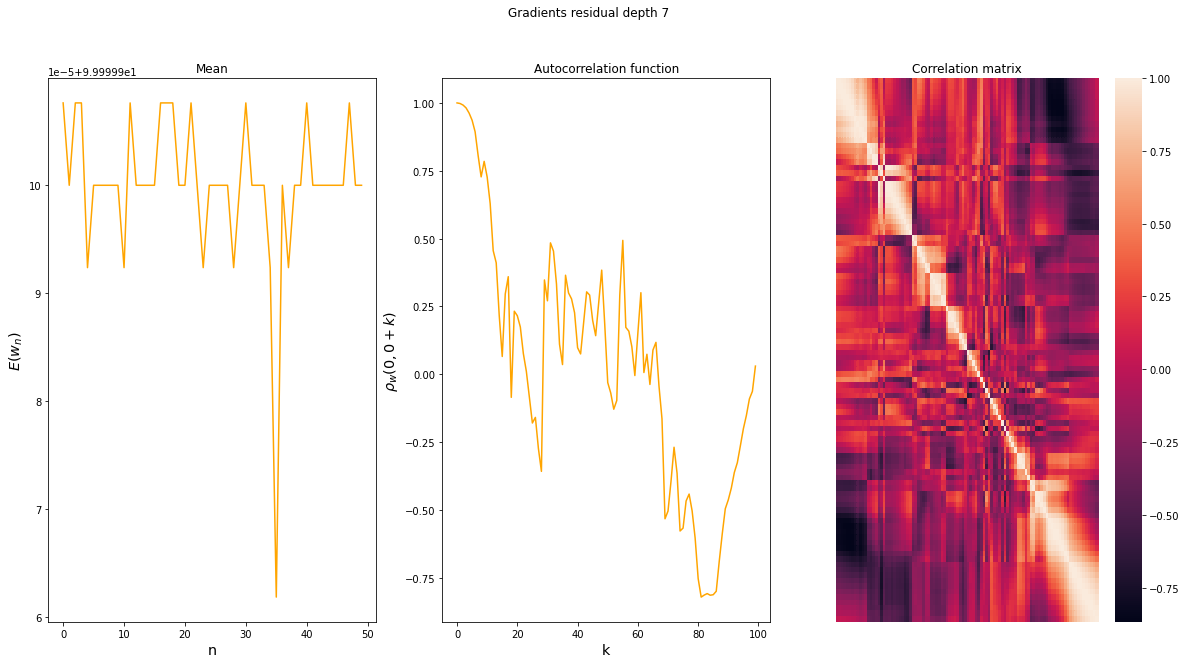

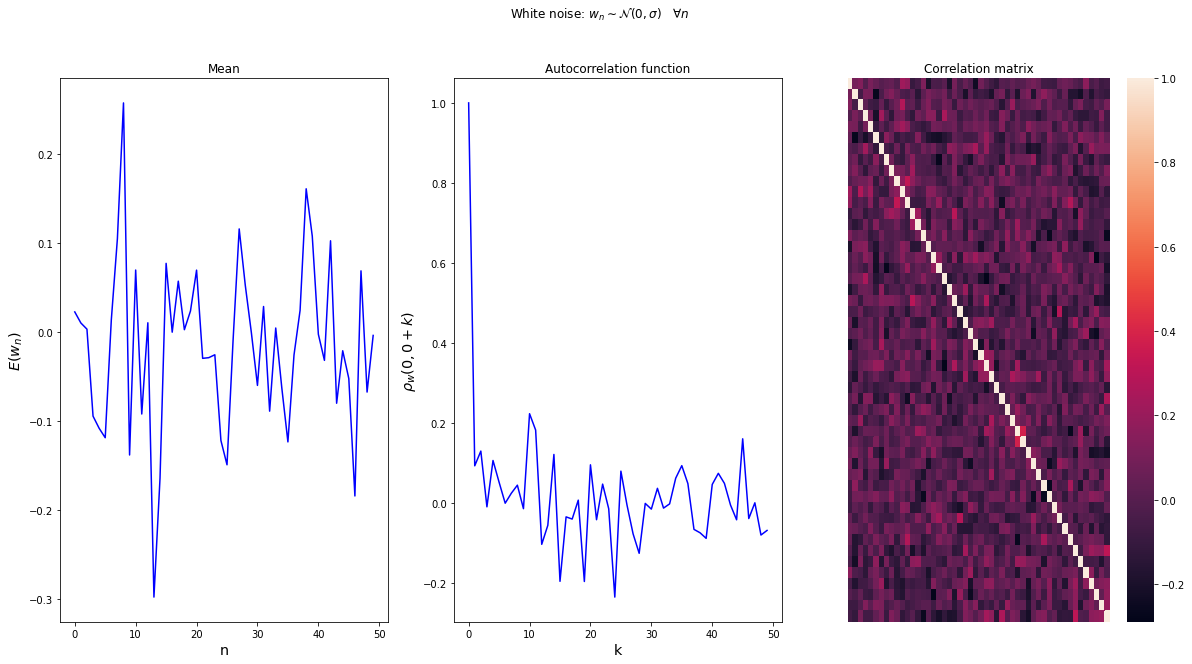

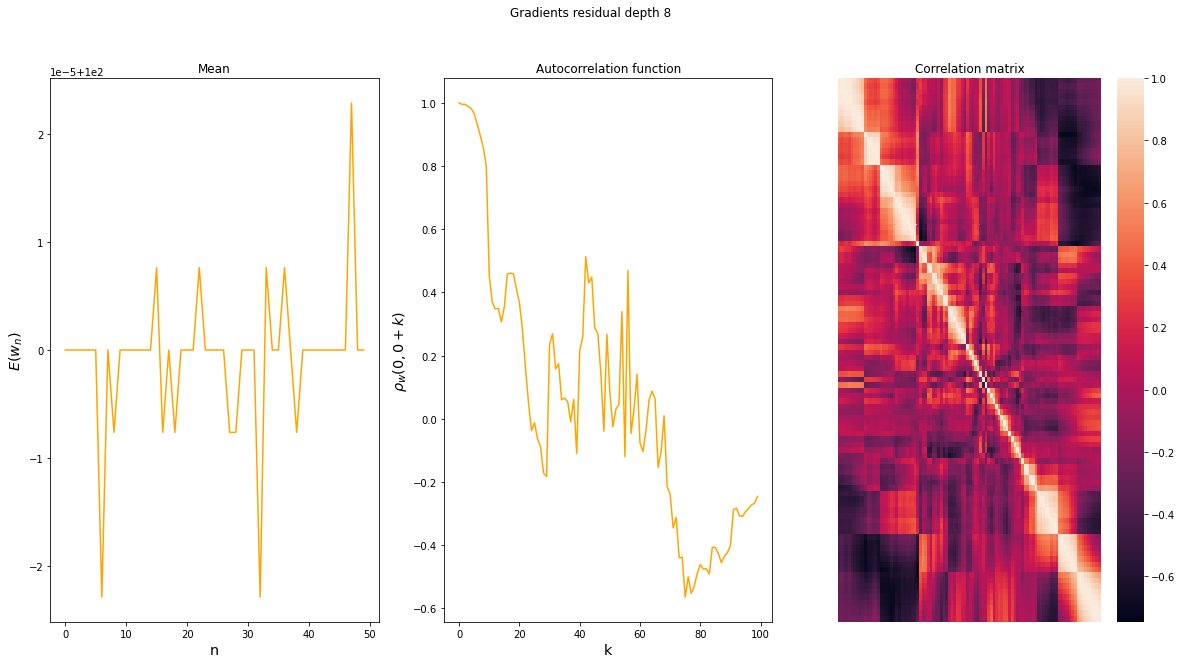

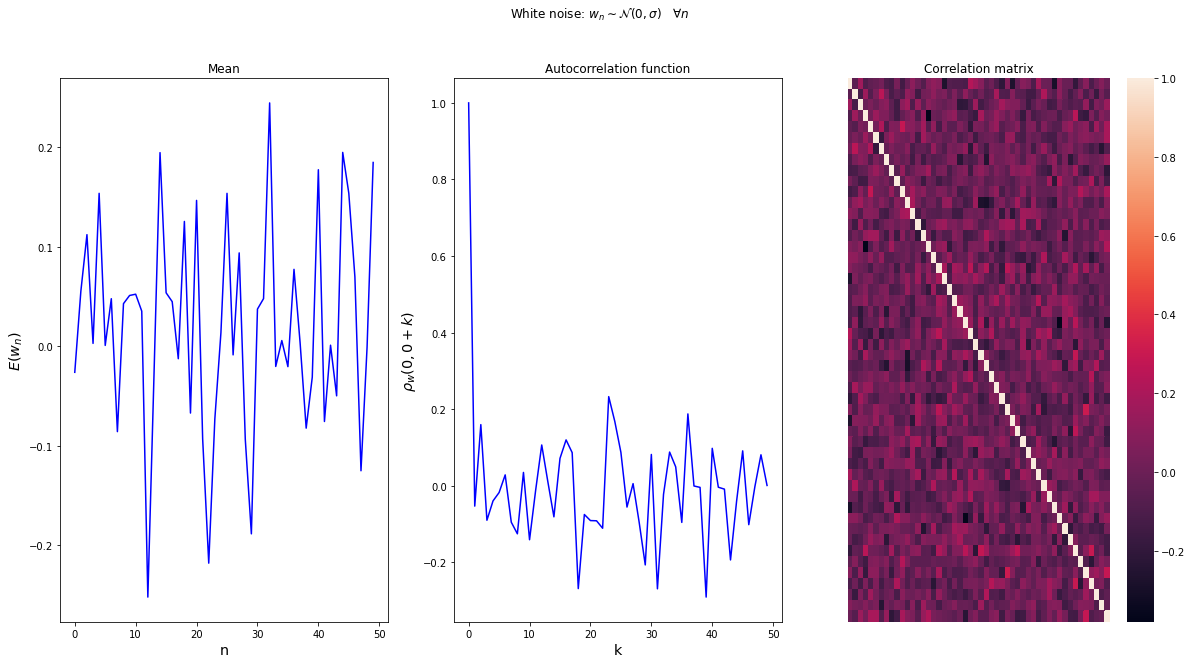

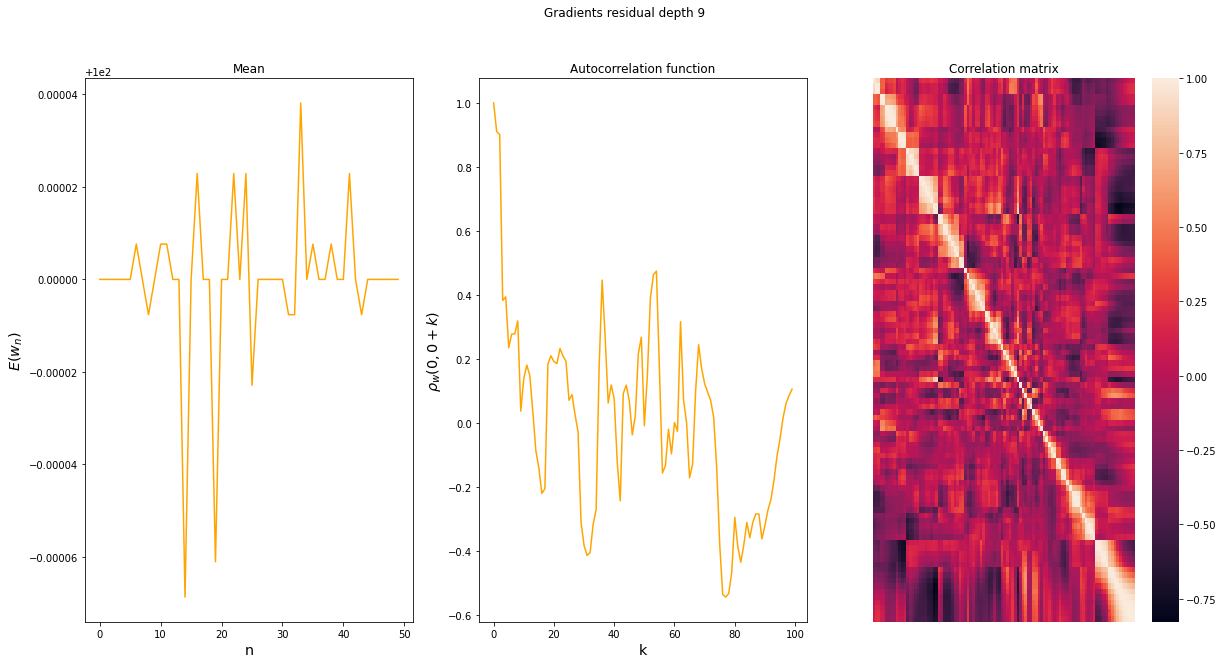

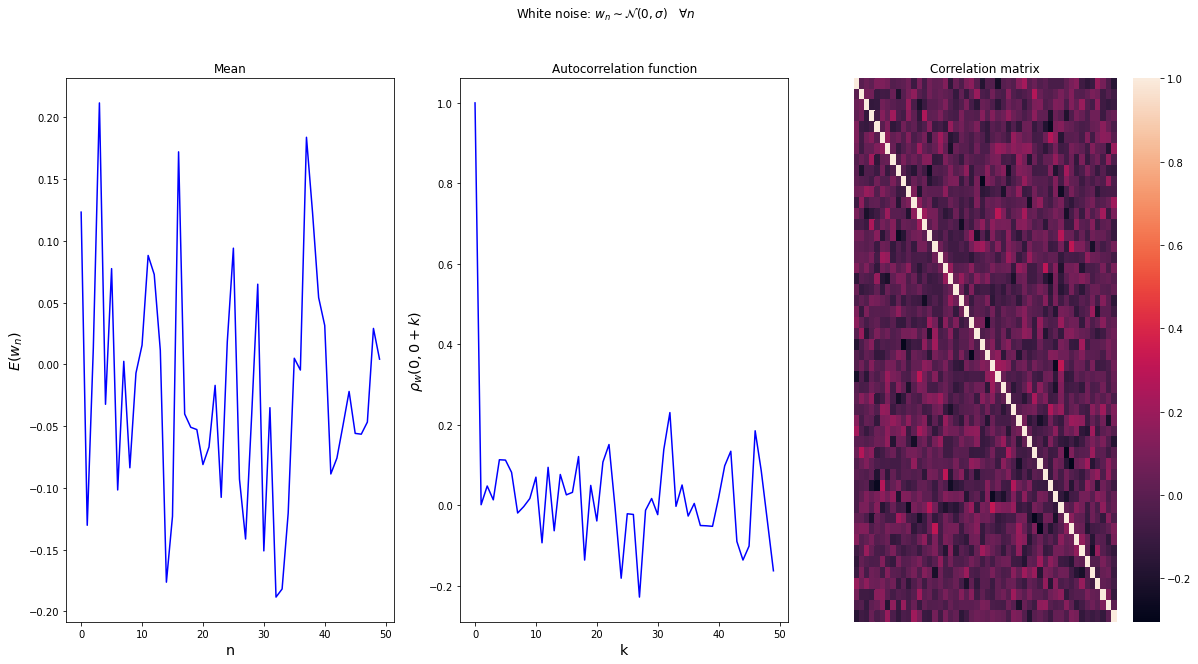

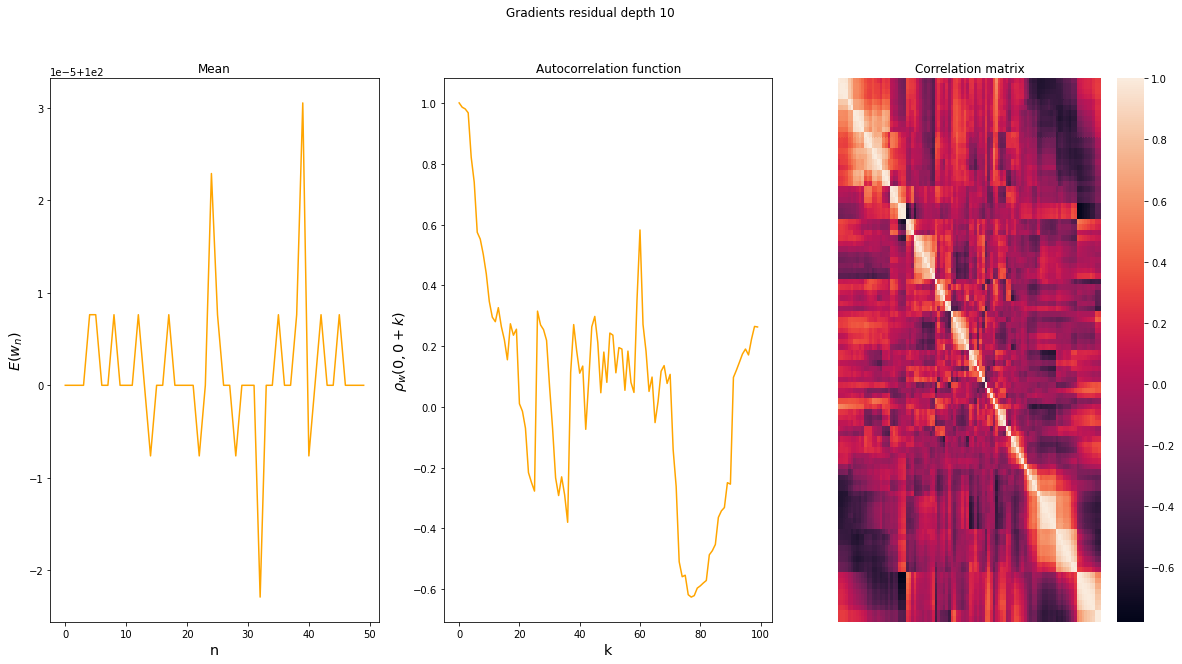

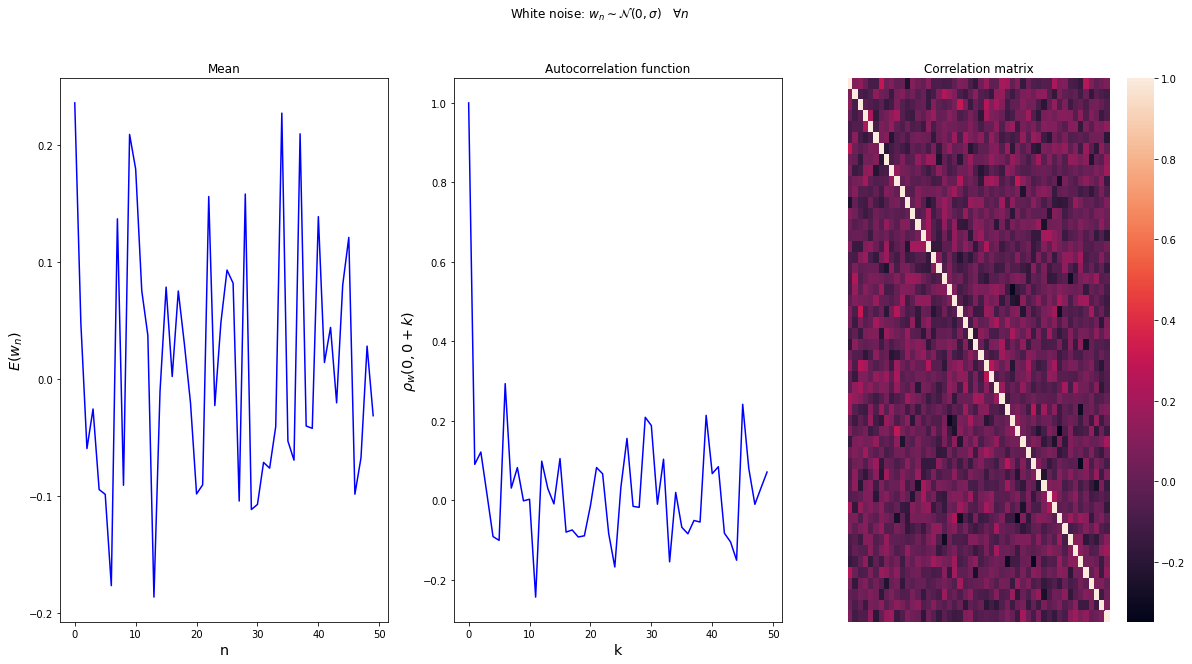

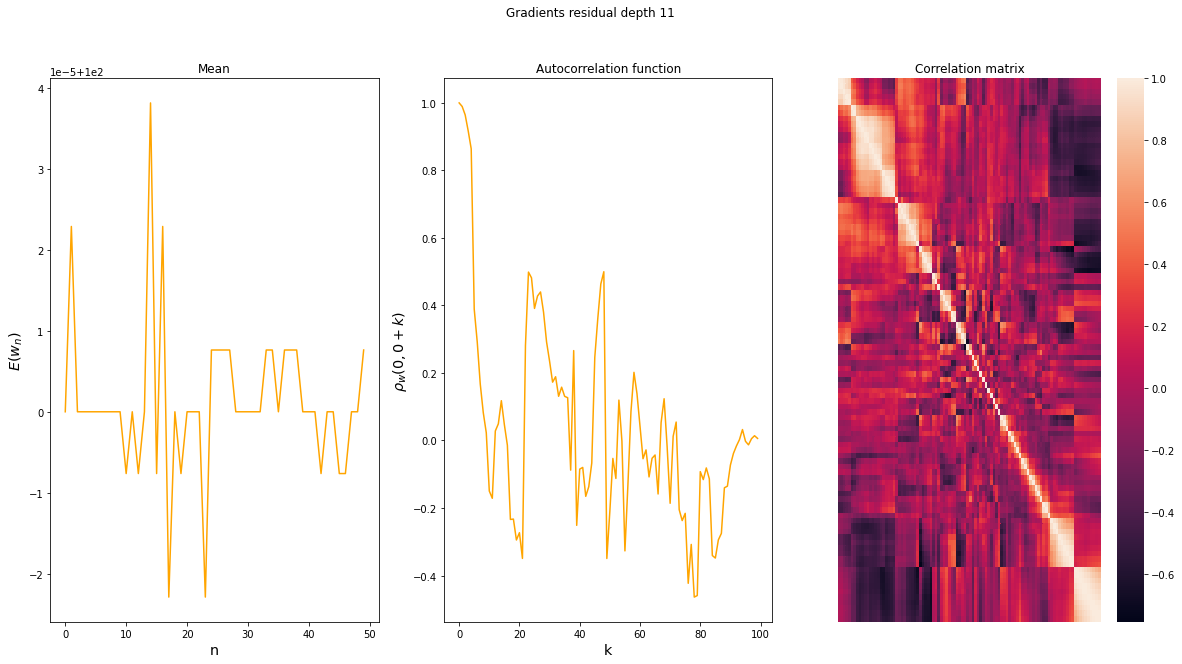

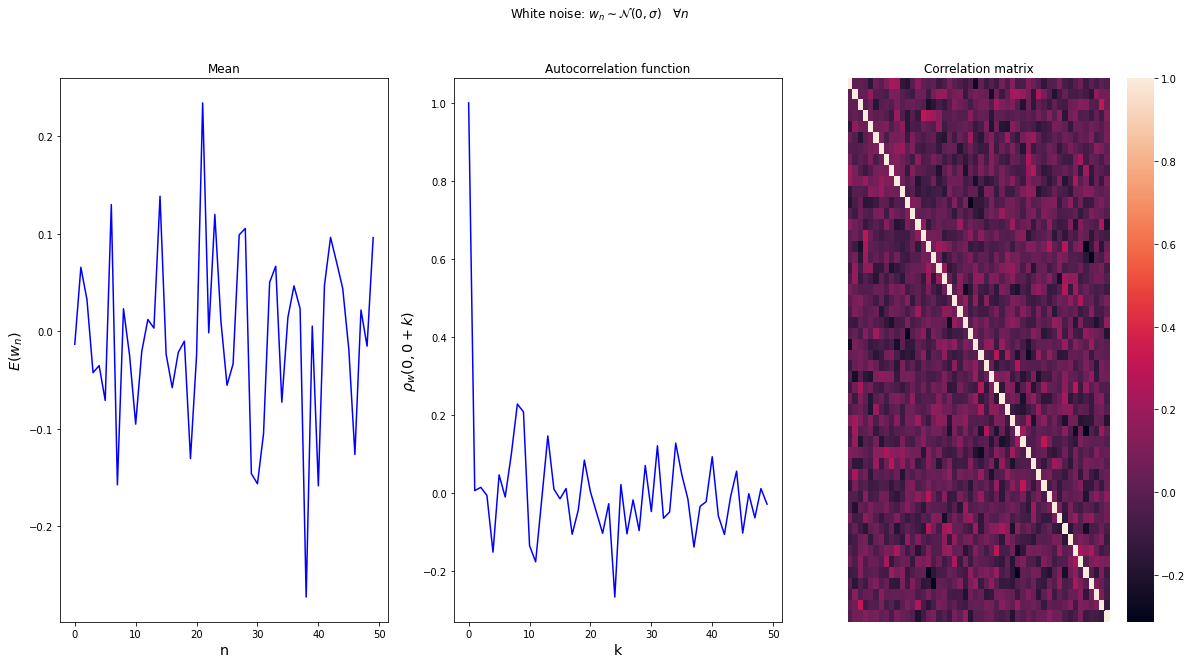

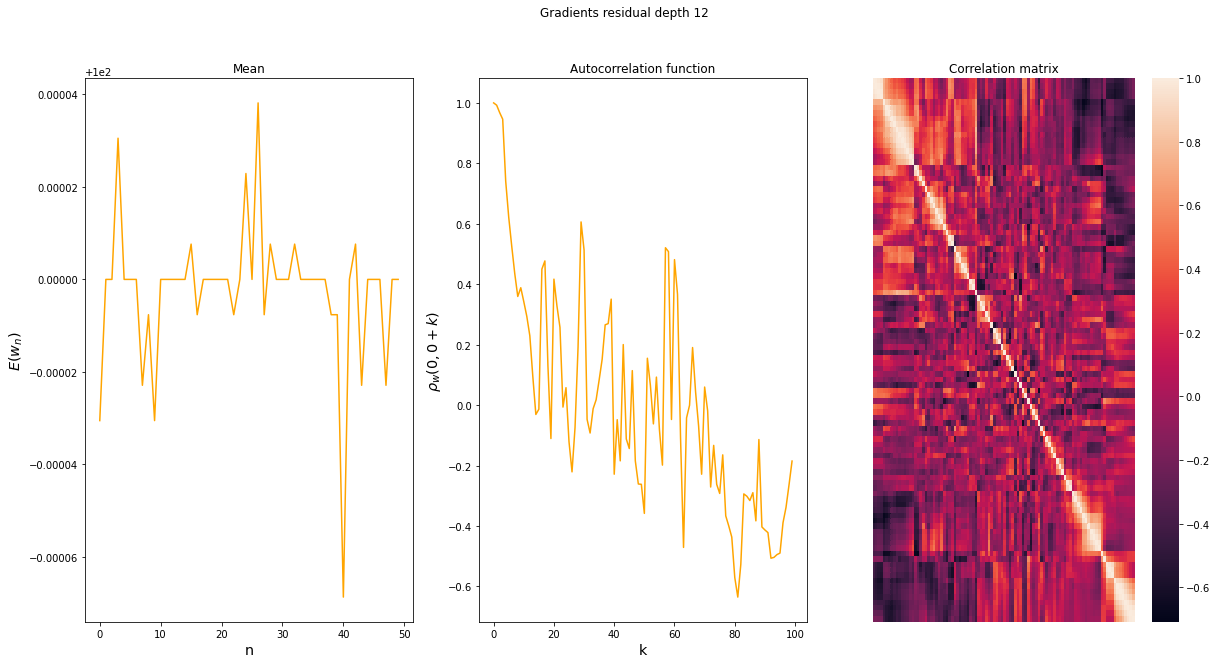

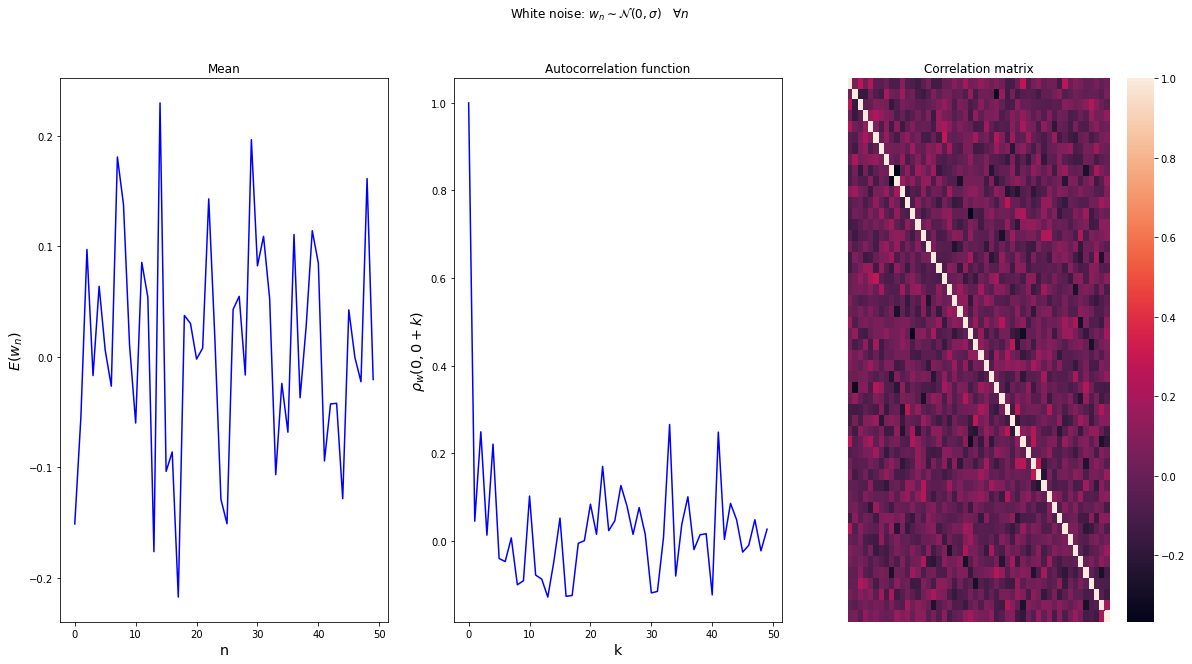

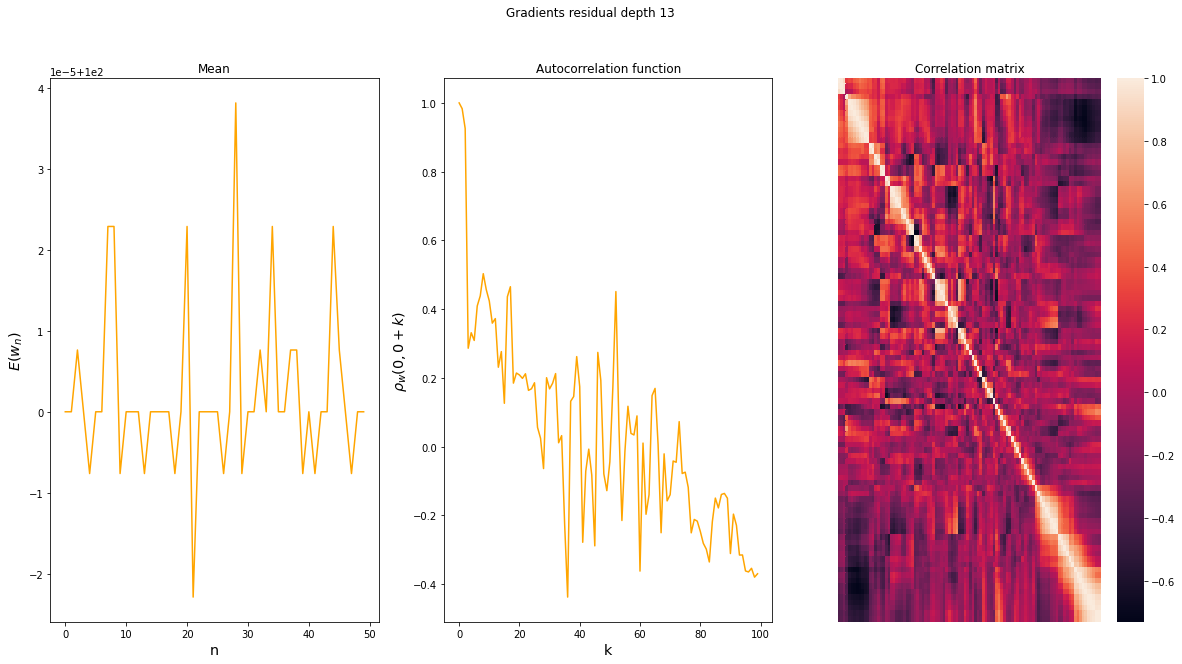

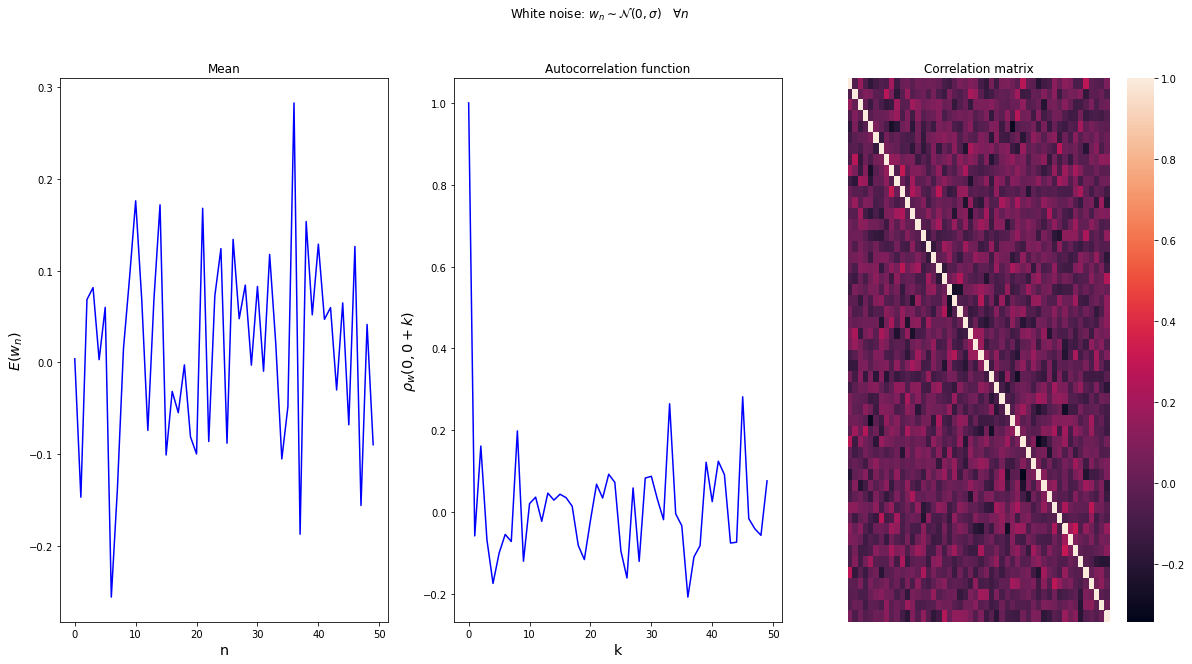

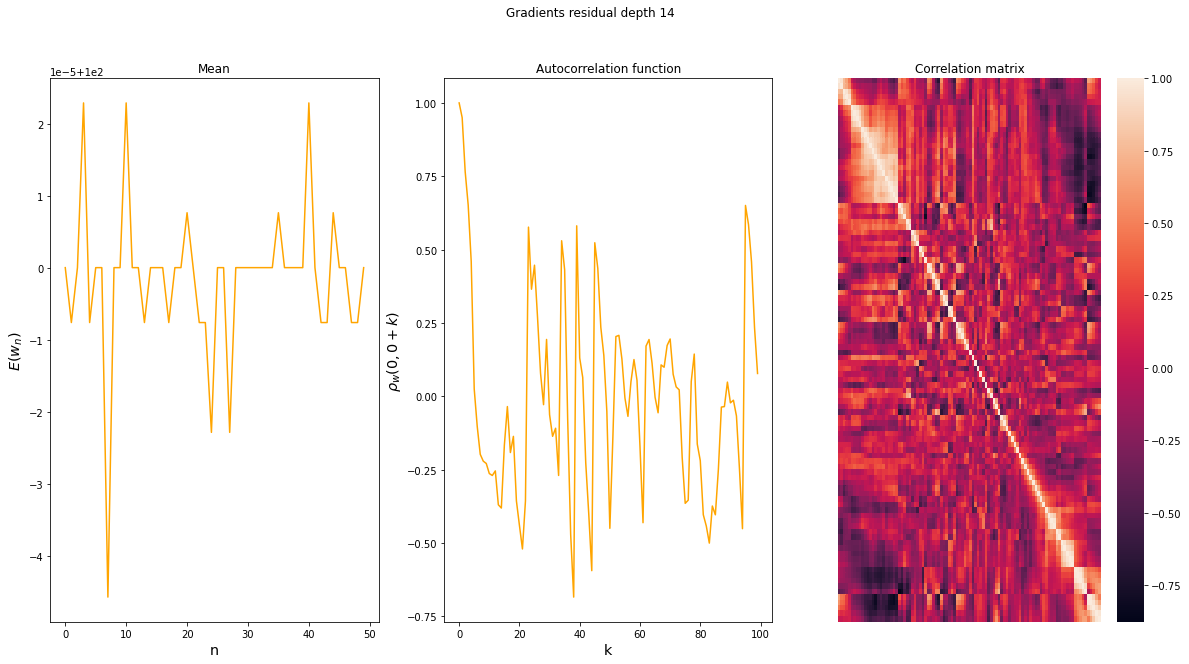

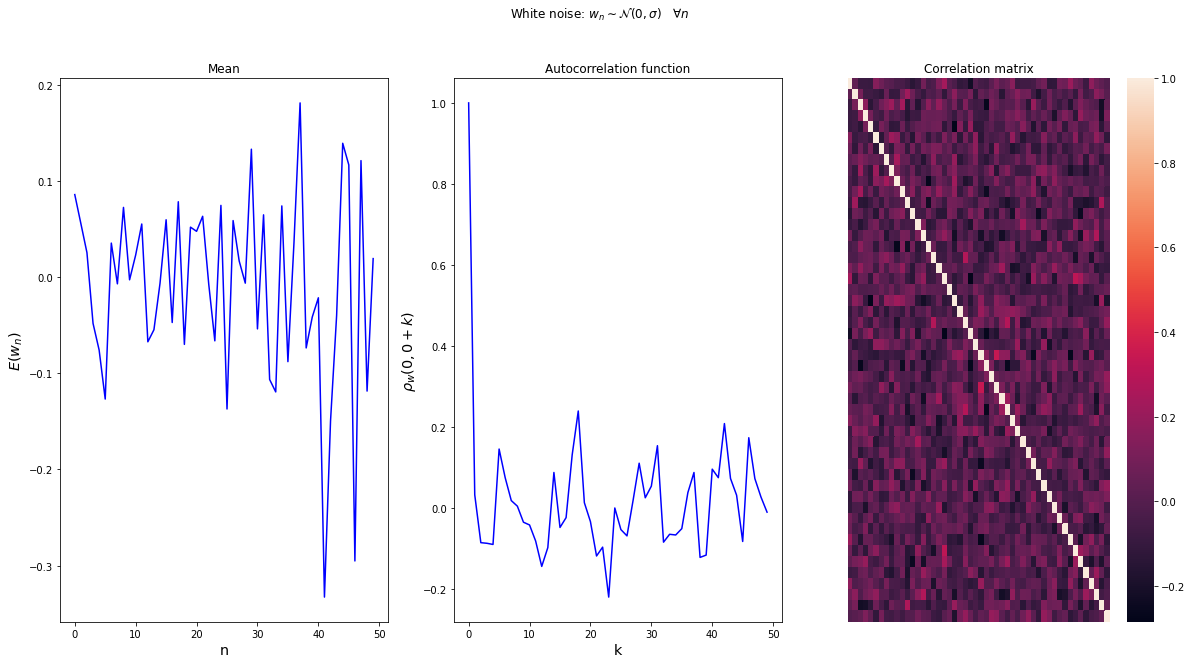

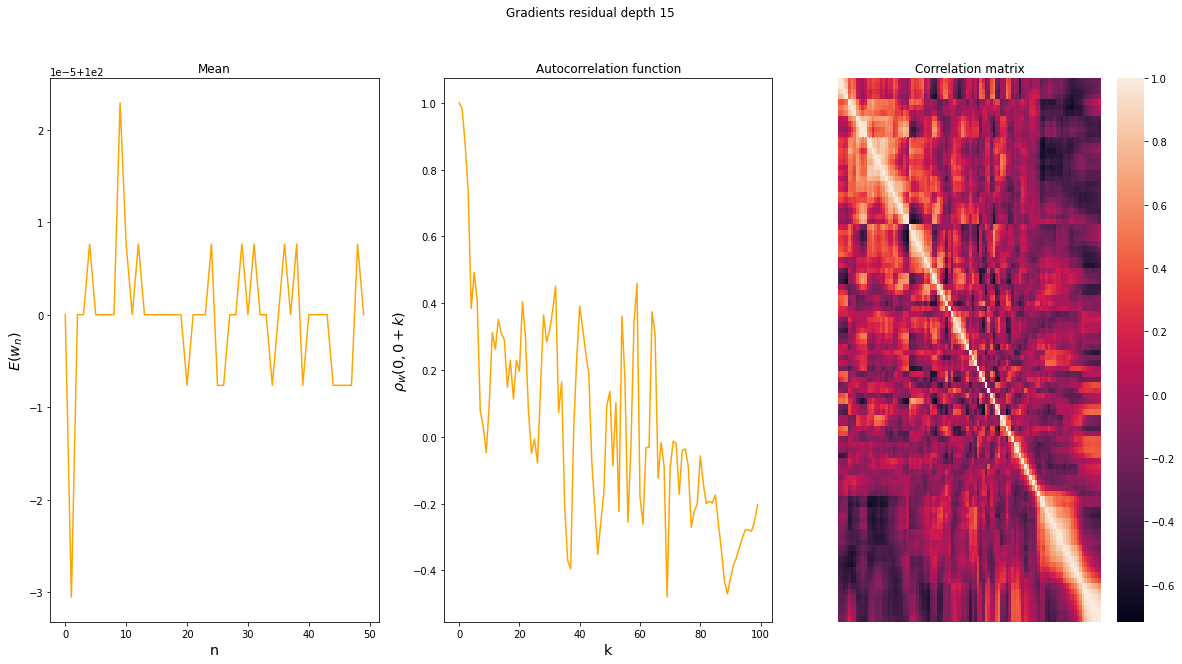

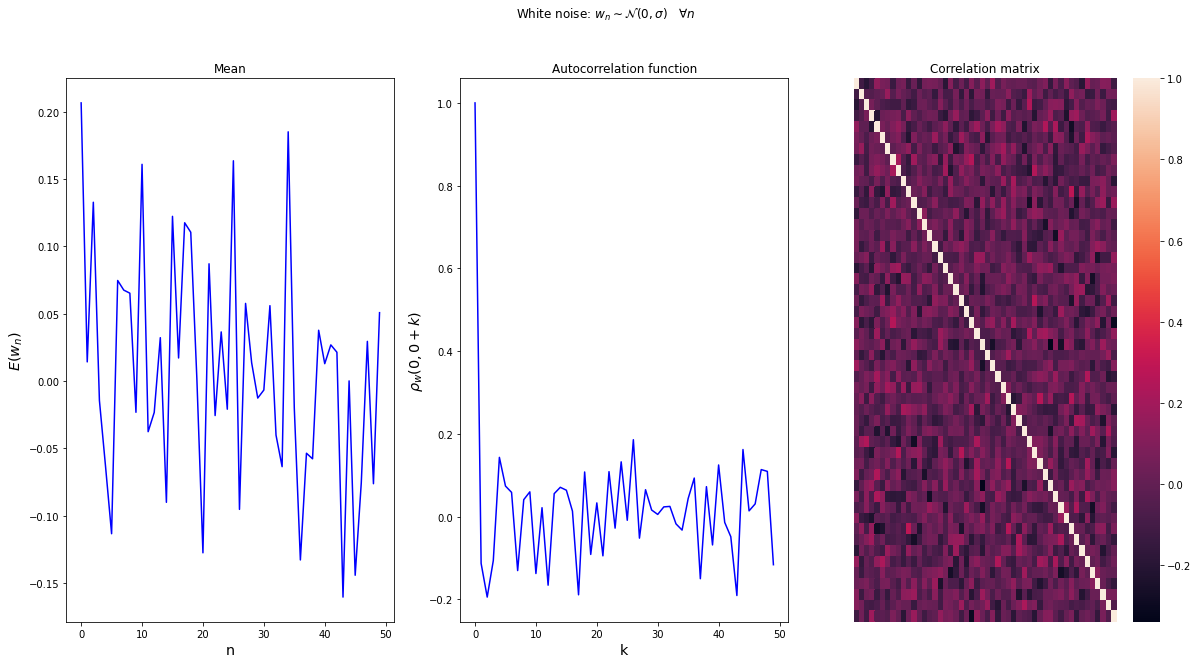

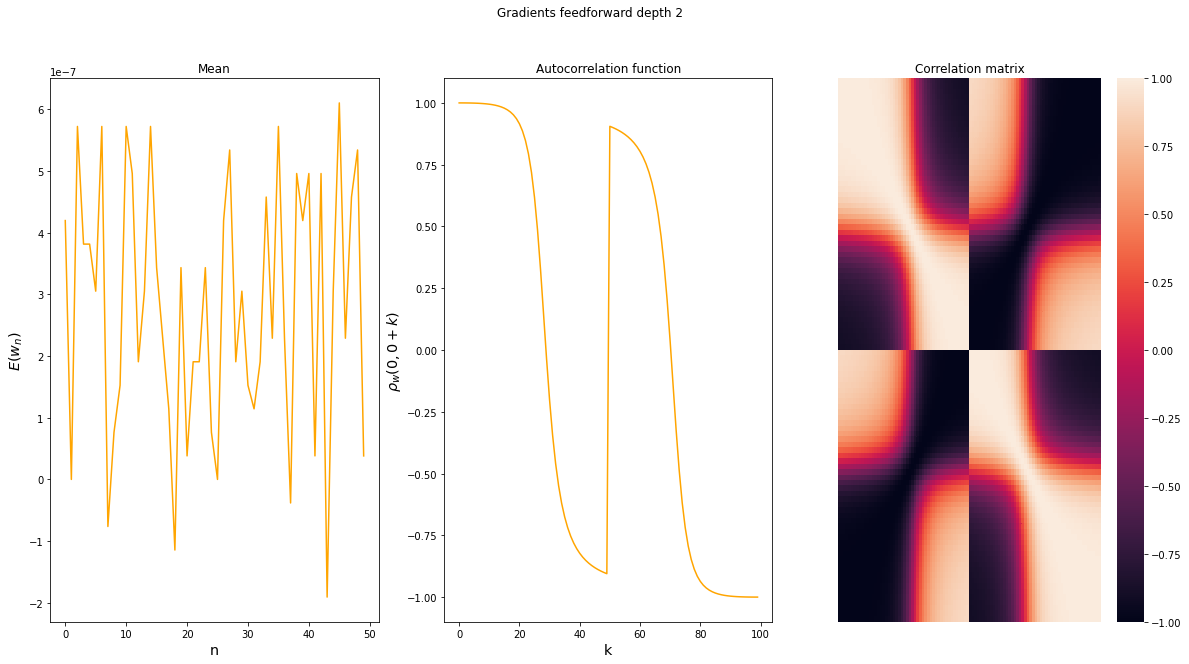

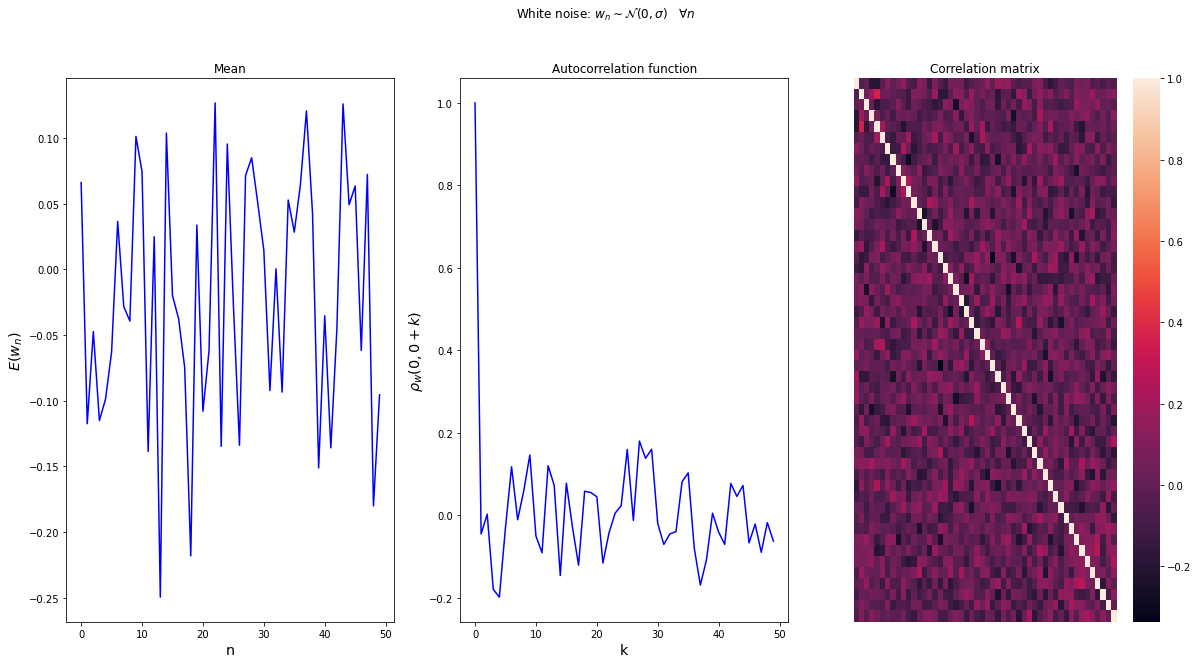

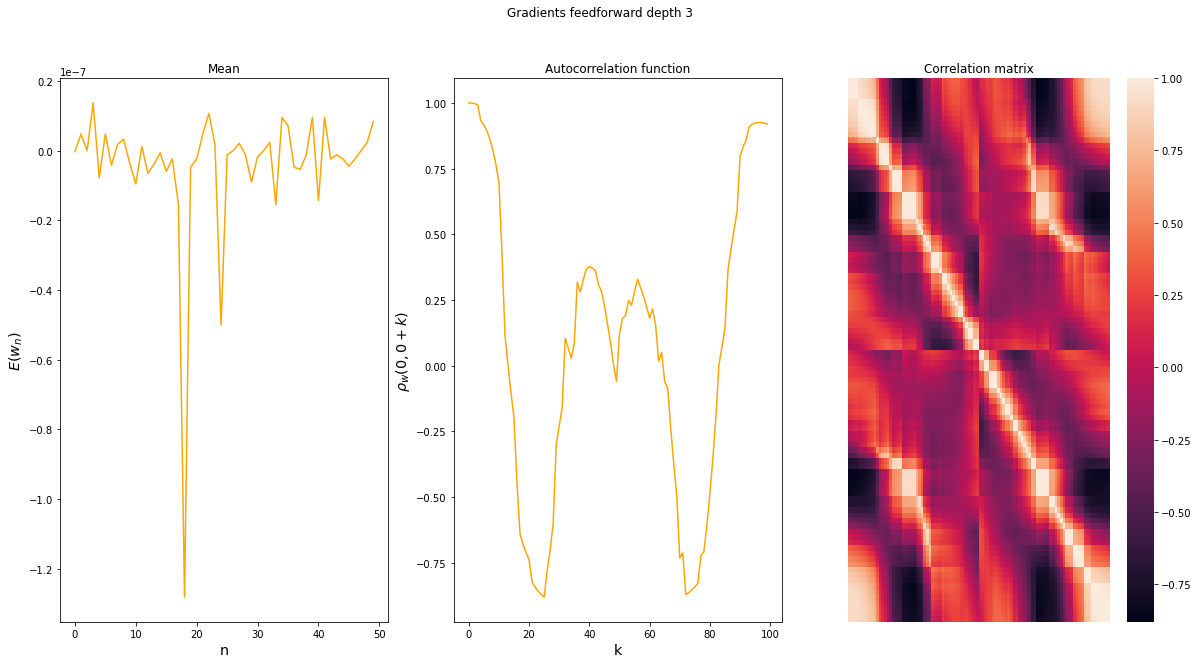

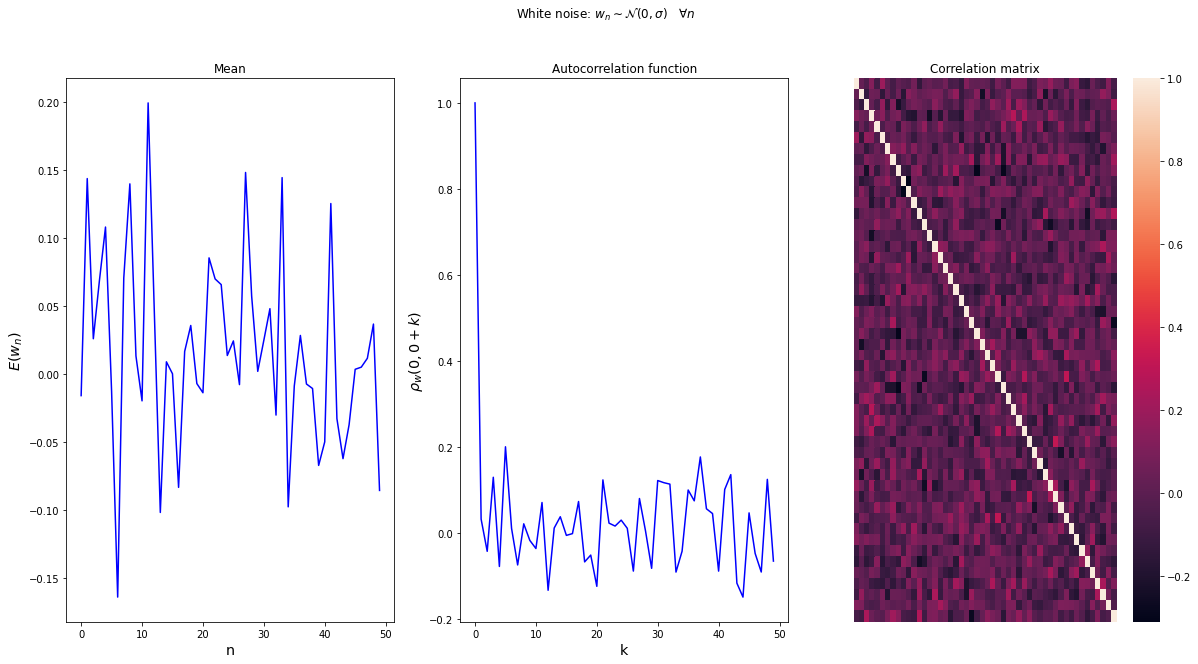

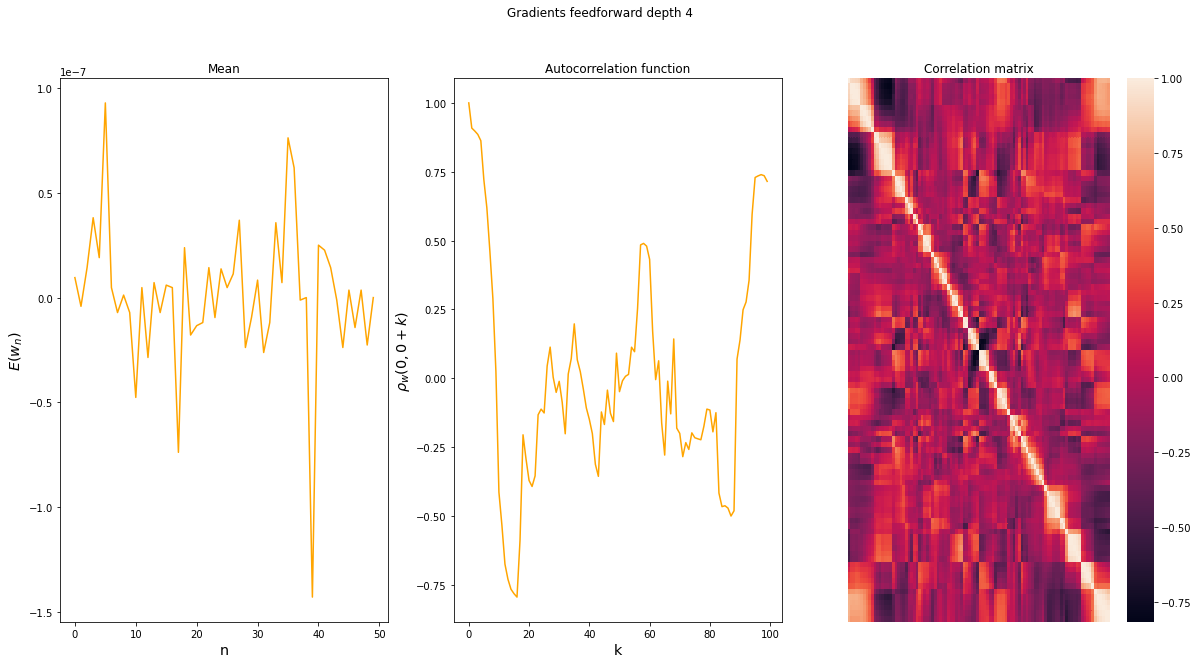

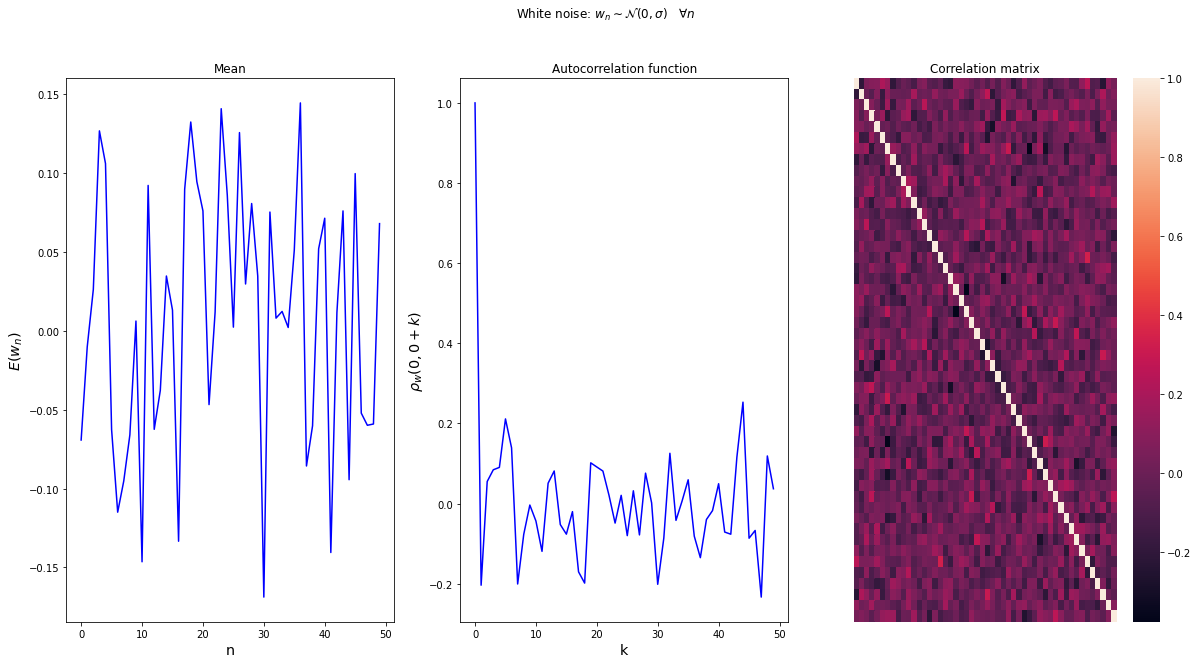

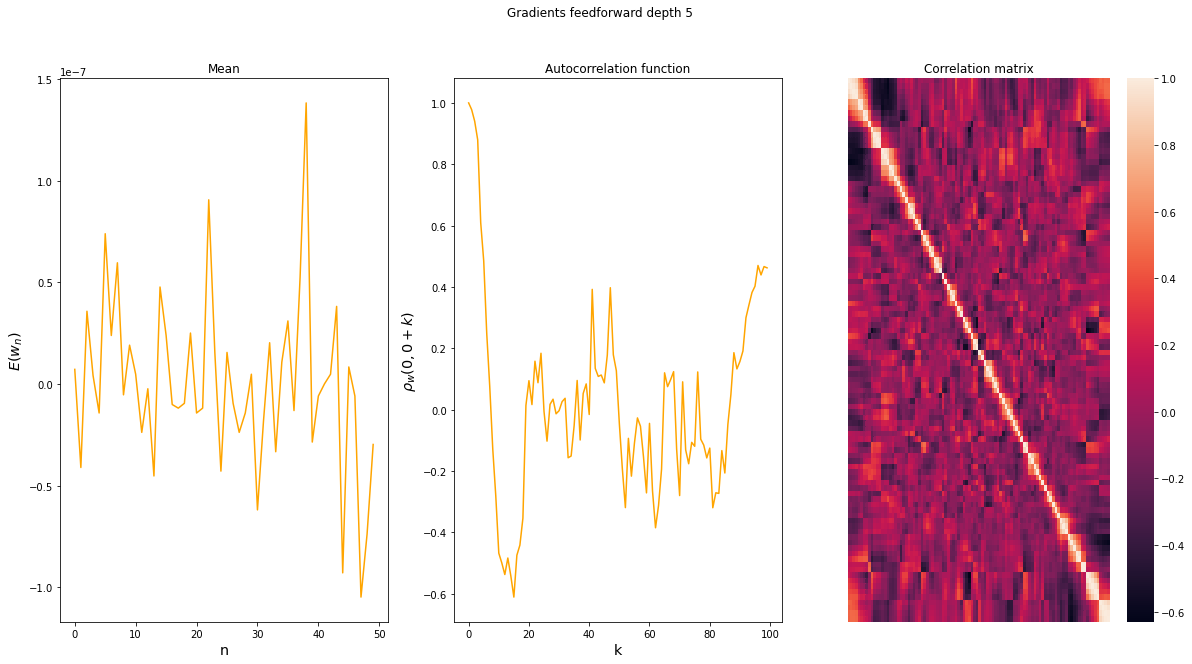

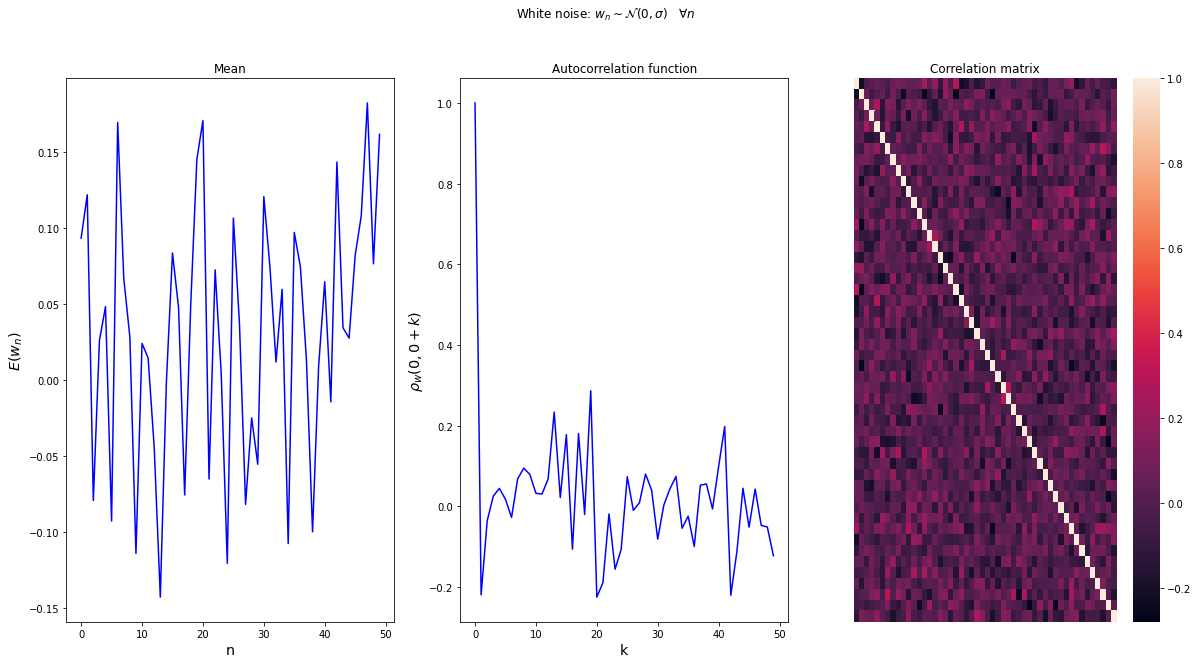

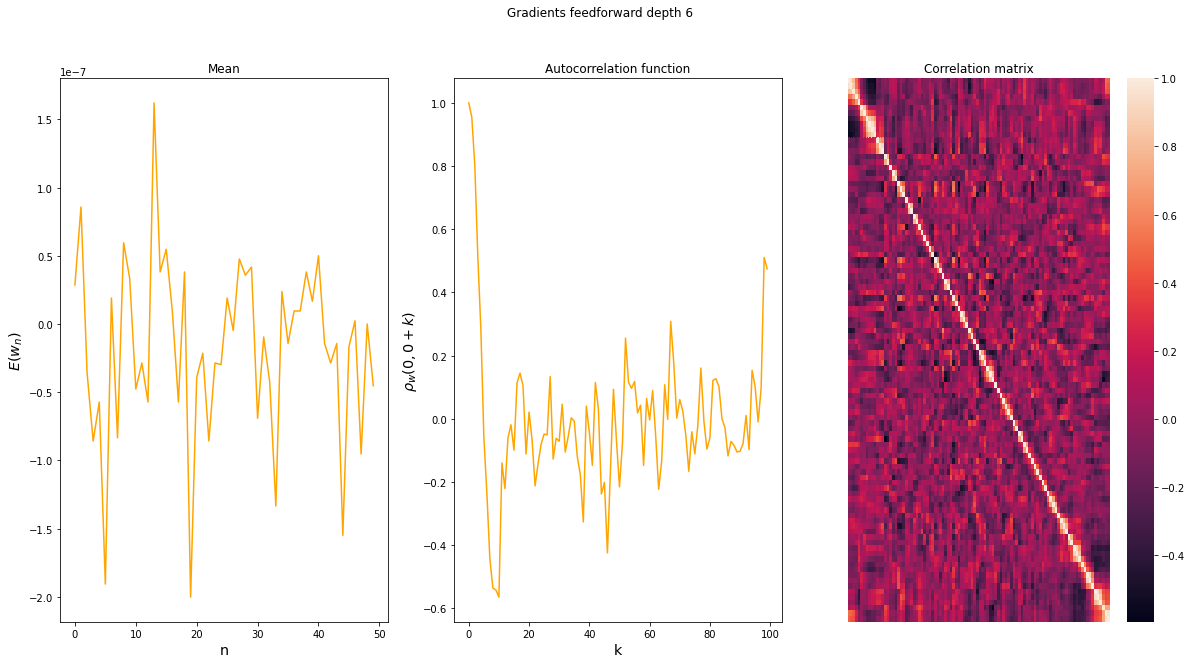

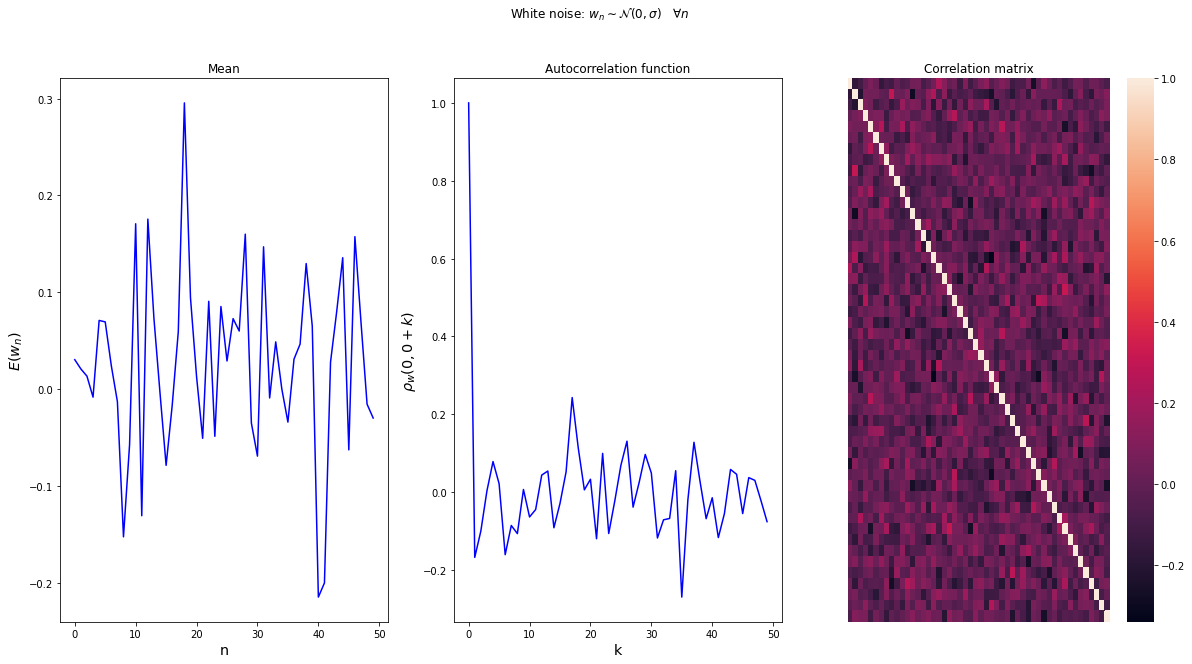

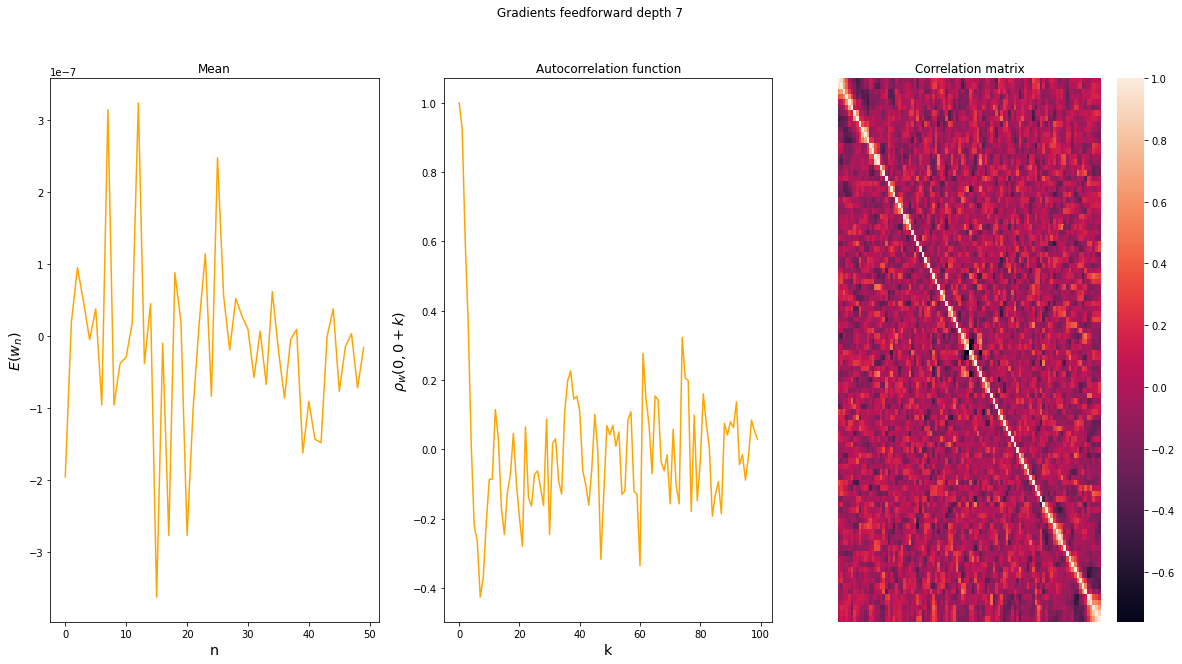

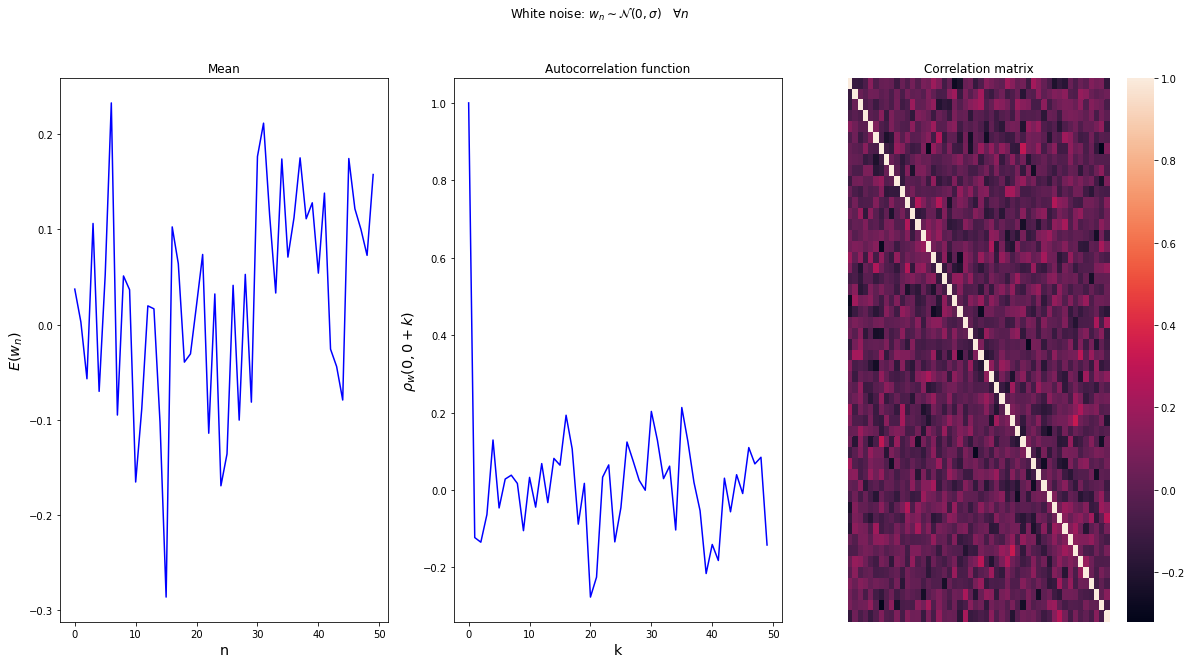

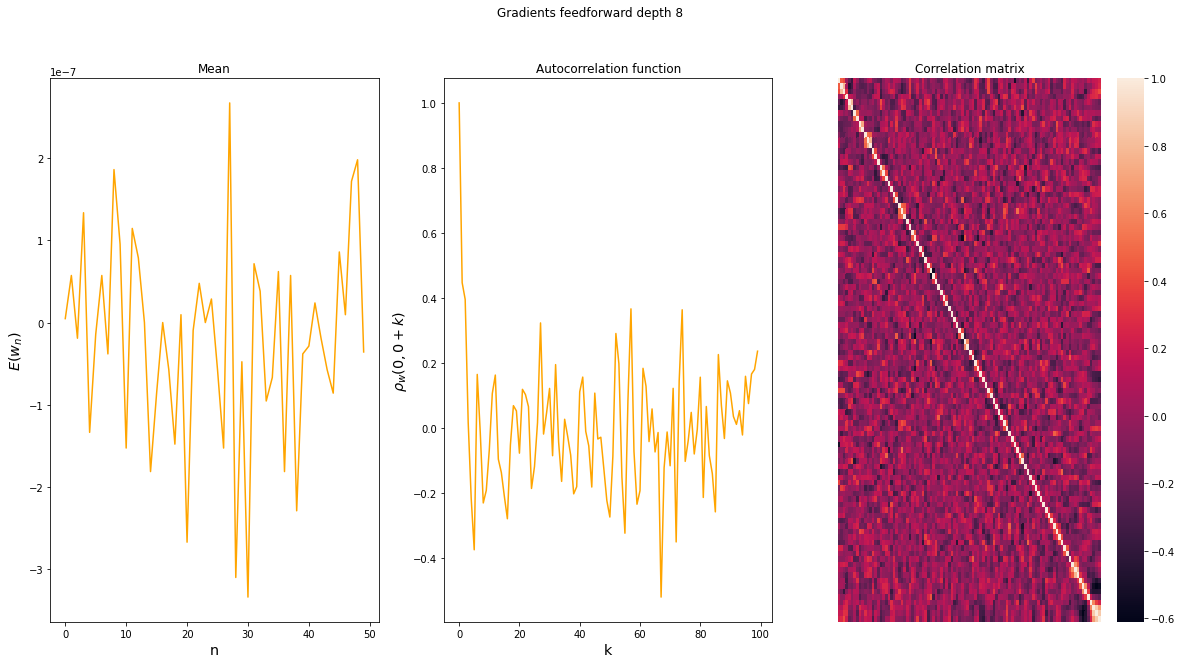

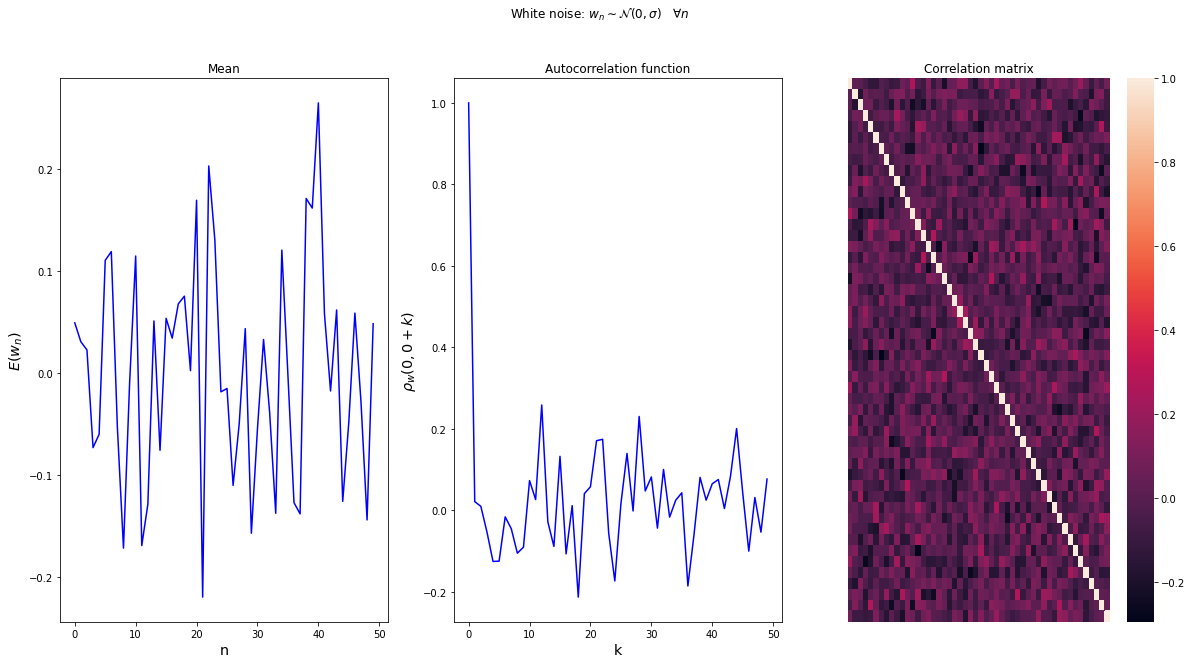

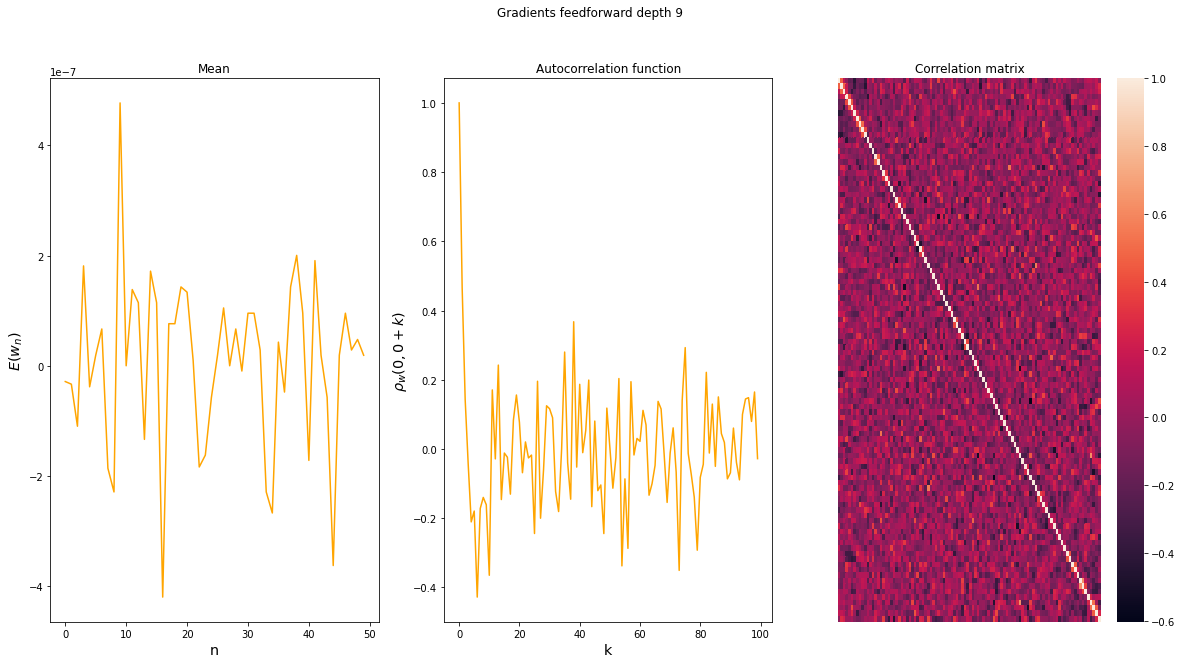

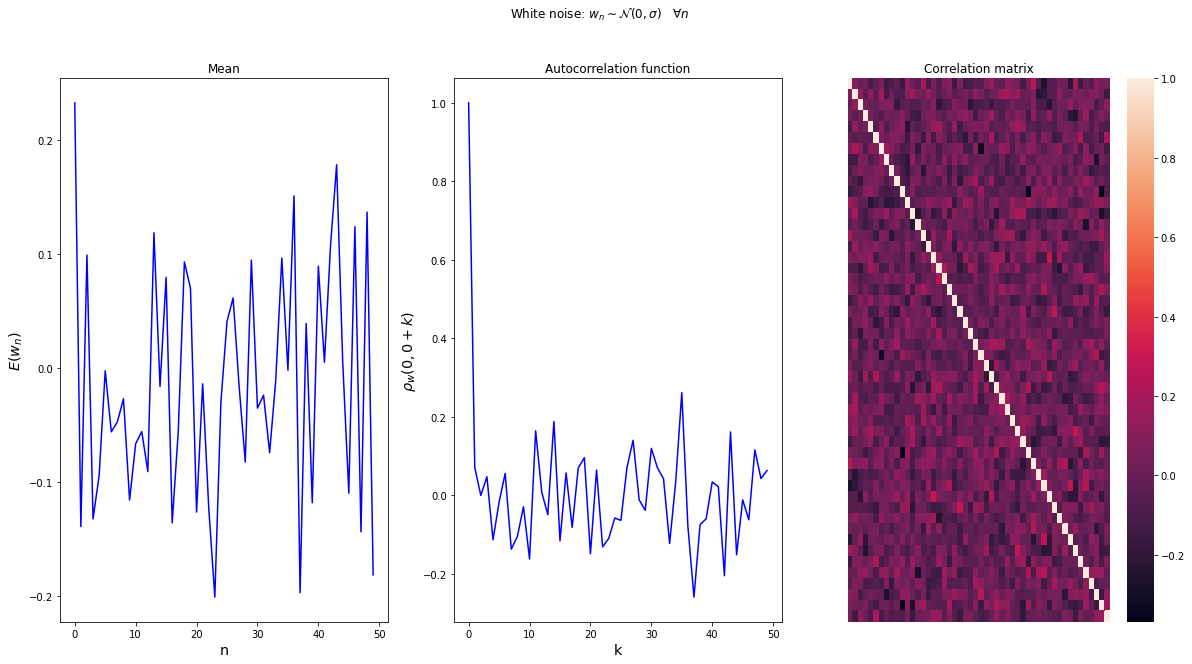

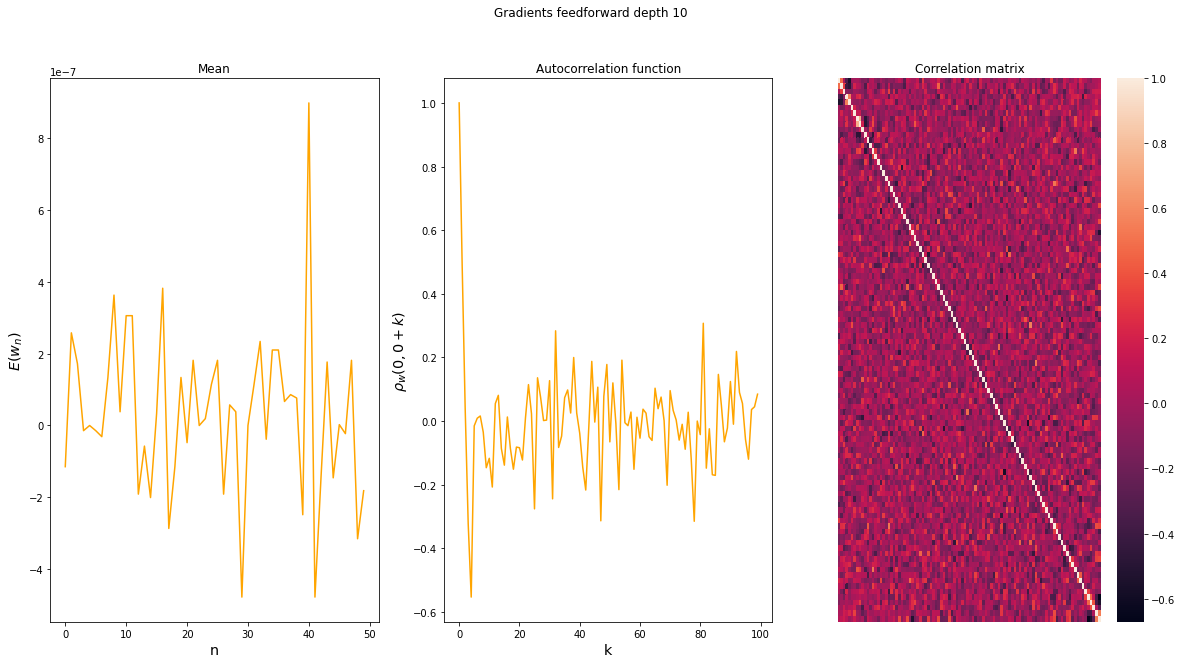

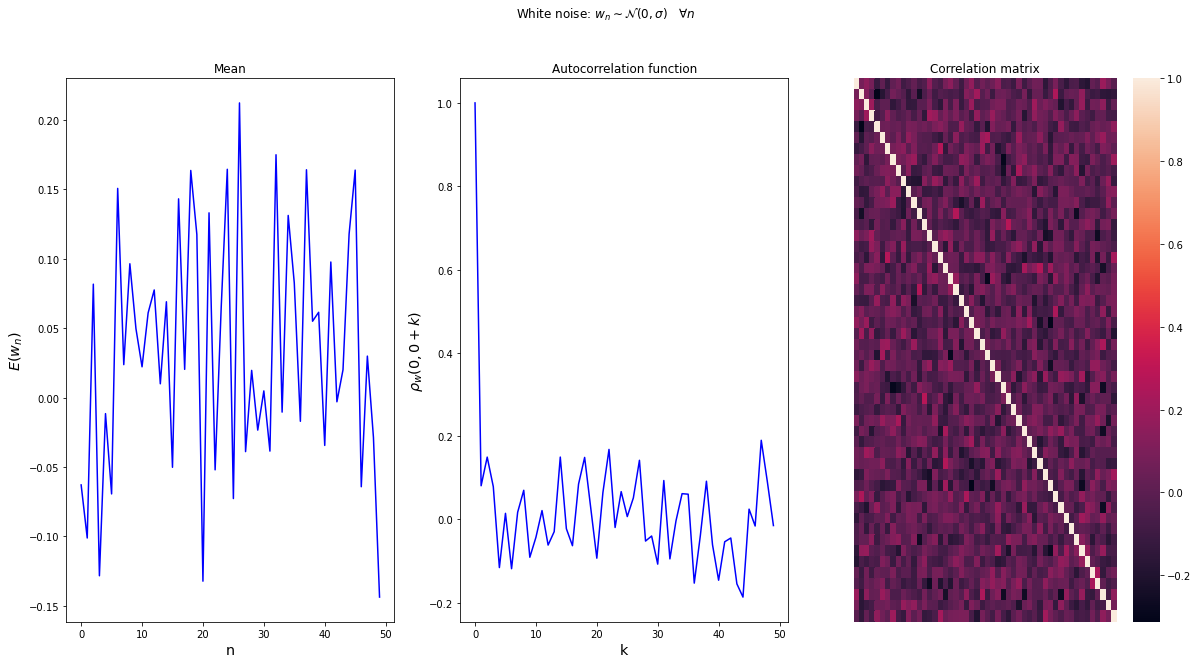

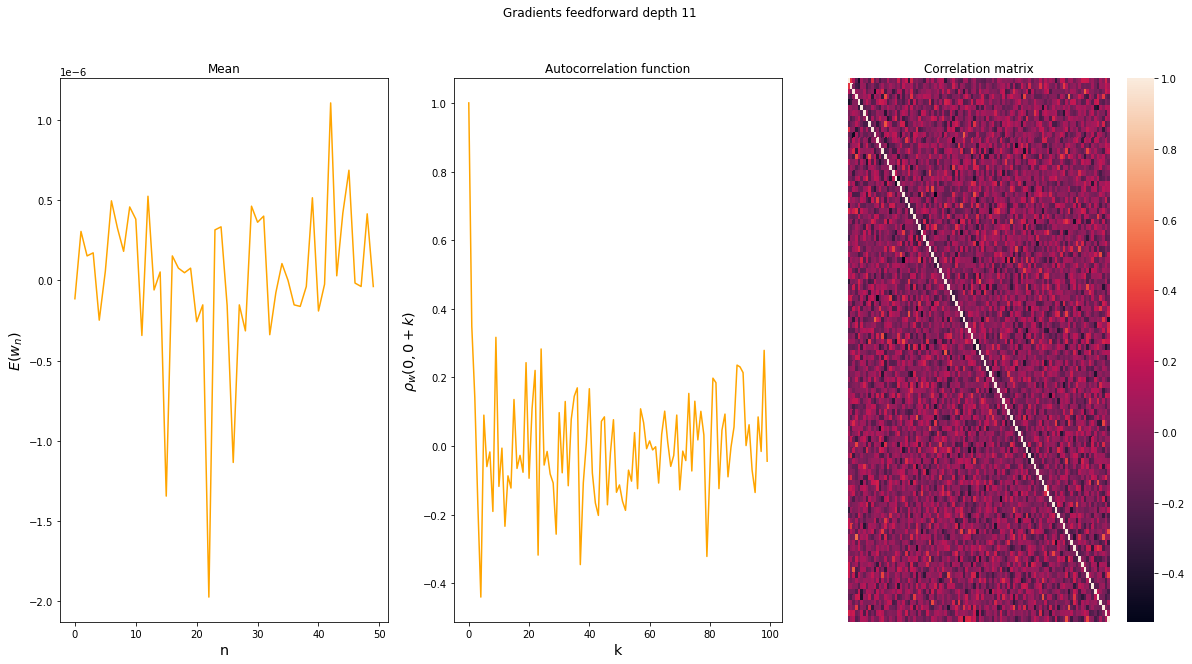

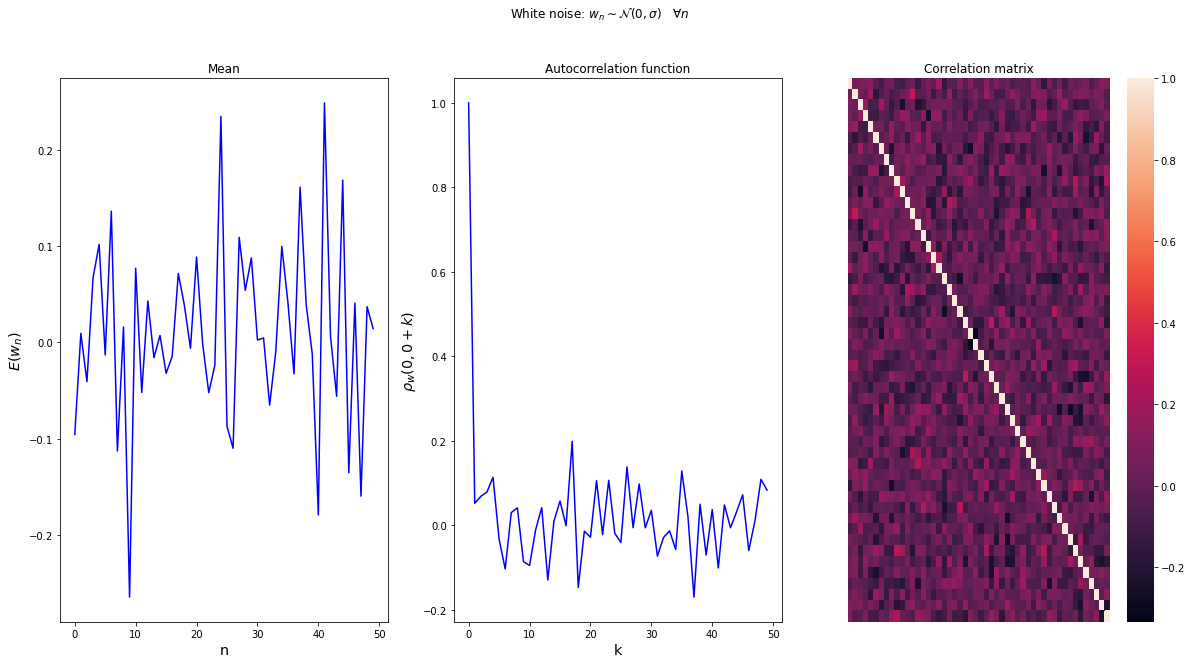

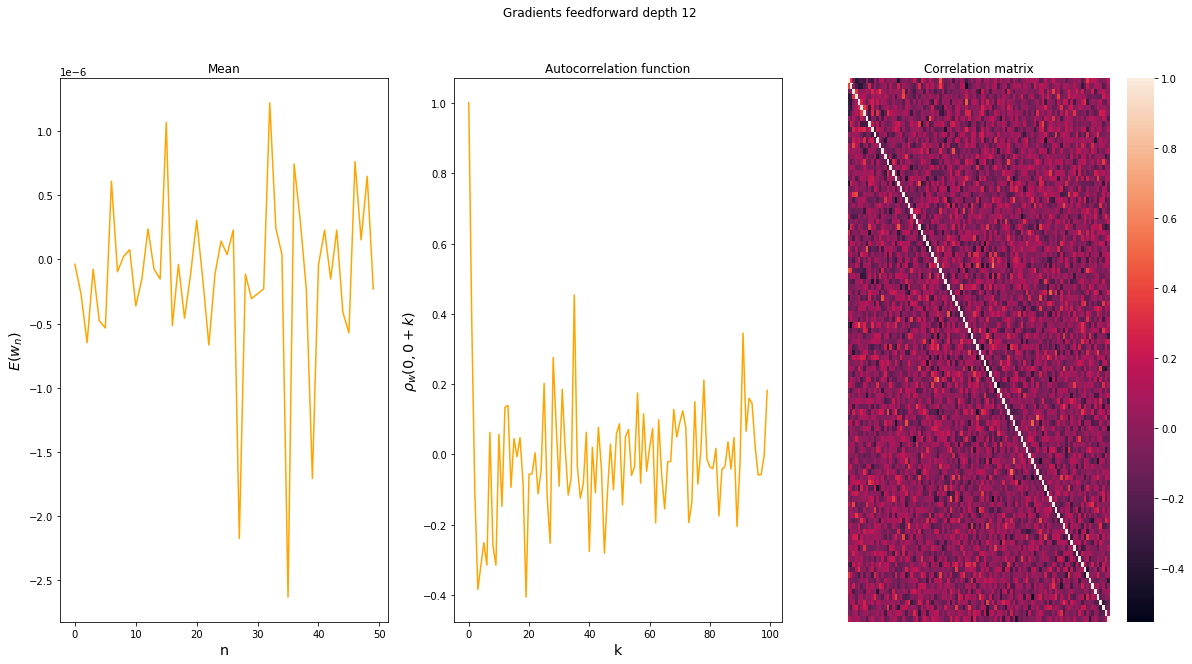

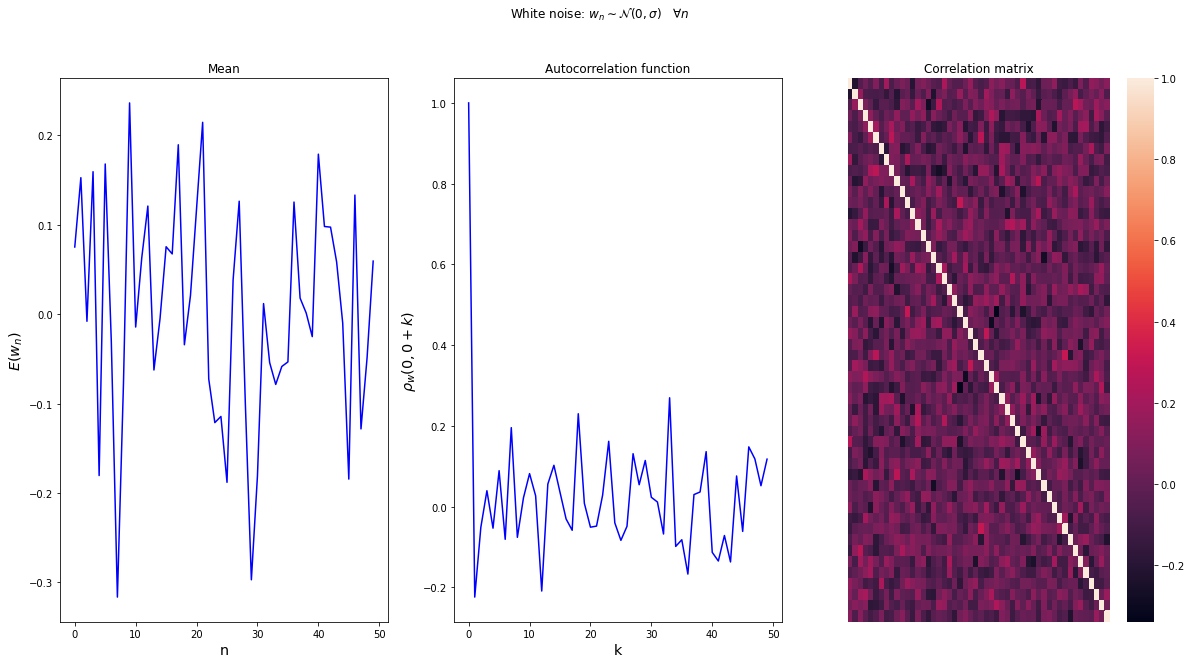

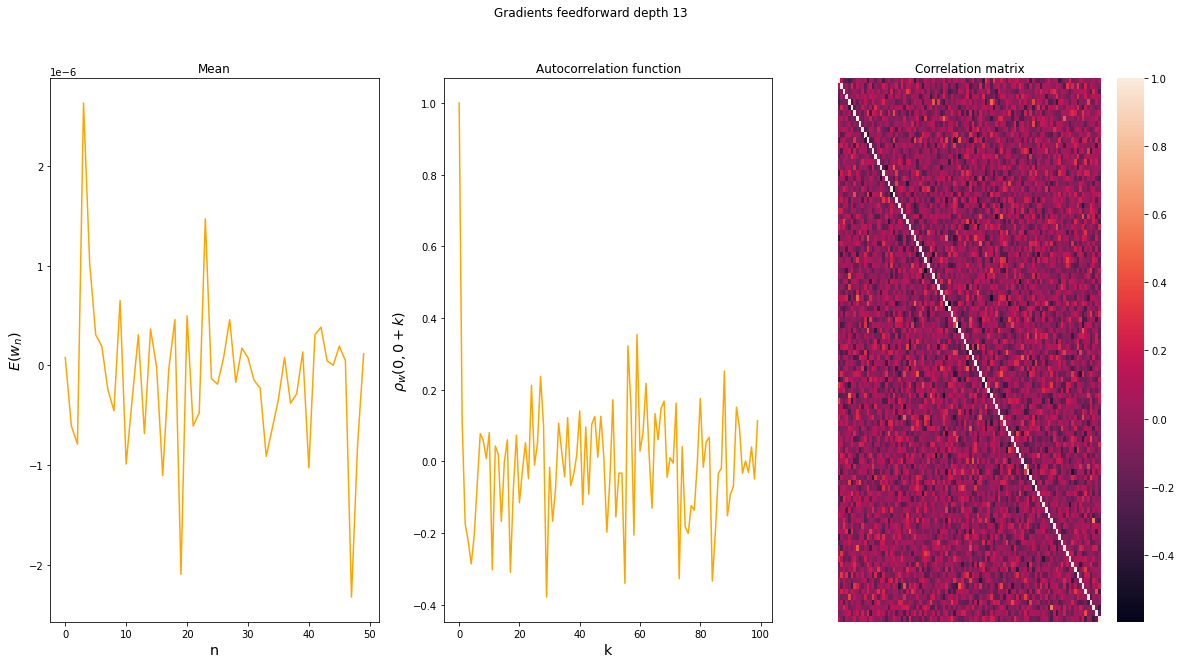

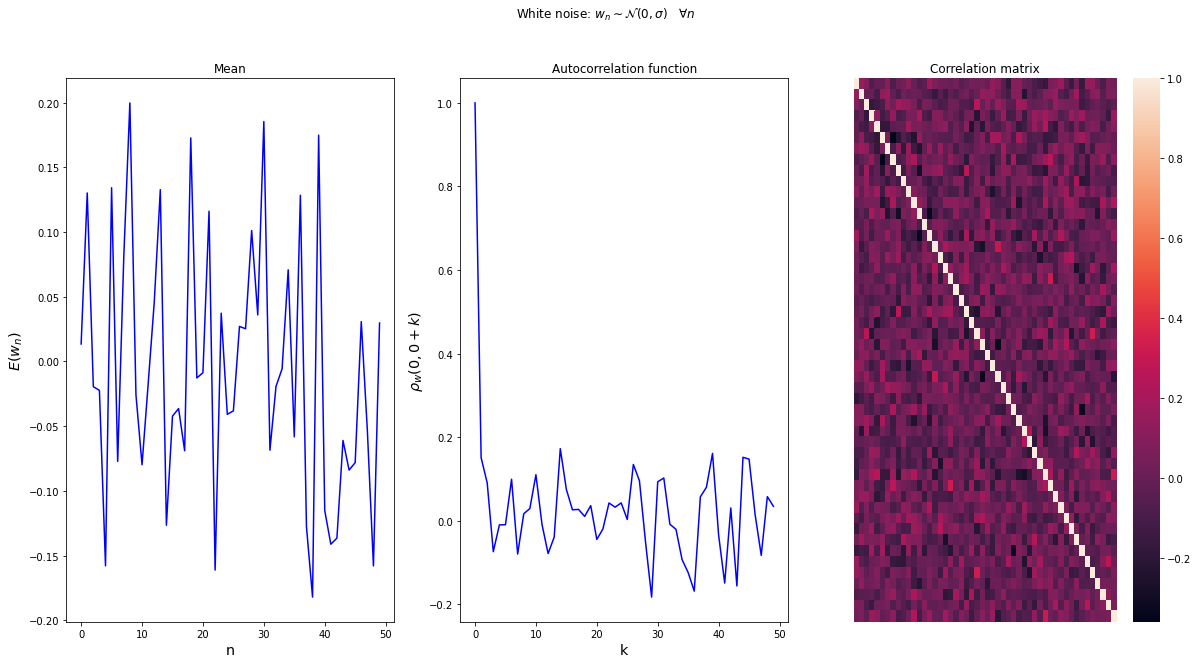

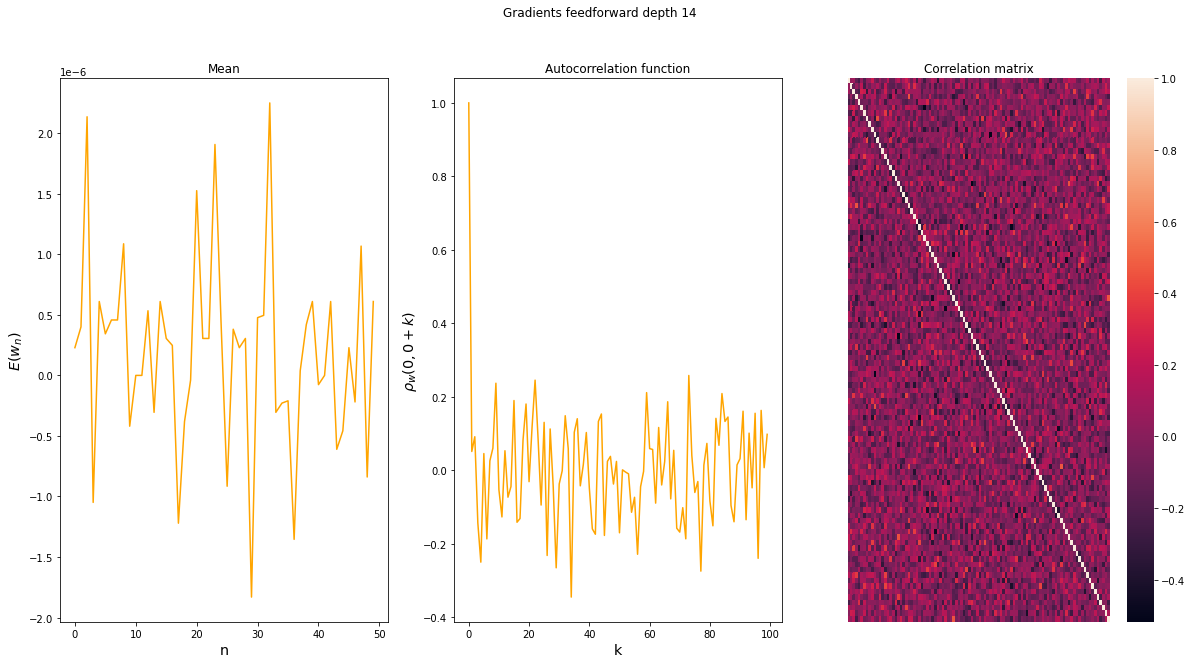

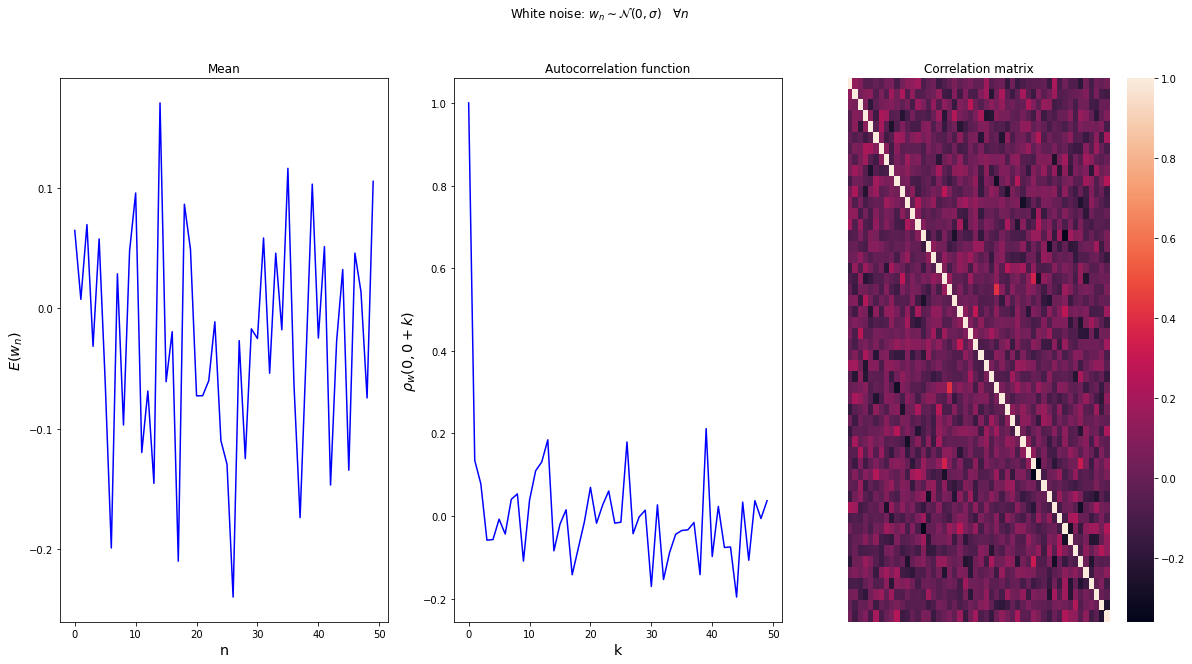

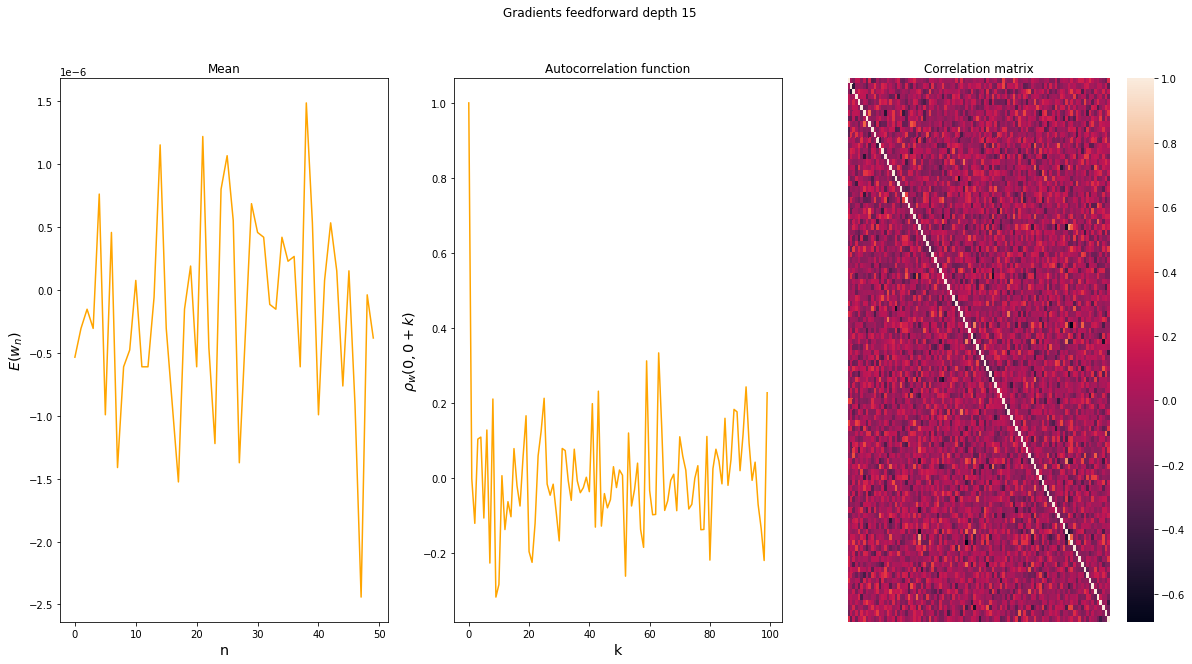

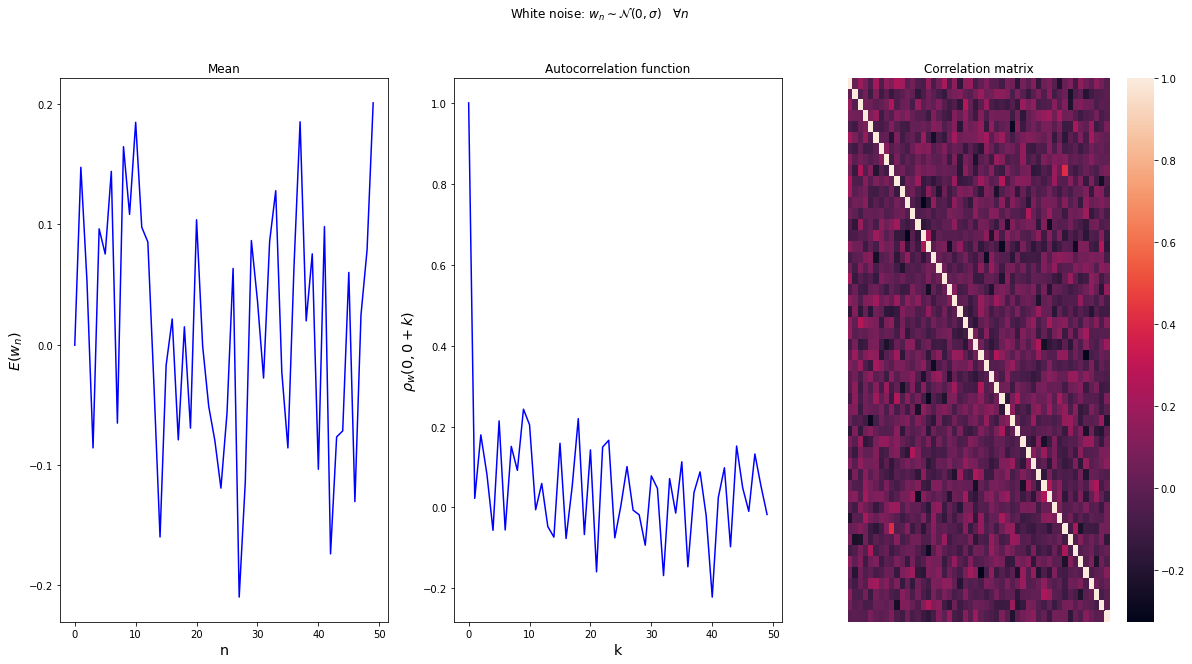

In [6]:
'''

TODO:
1) Visualize white noise.
2) Create a 1D data tensor x consisting of (>= 100) points uniformly spaced between [-1,1]
3) Visualize gradients wrt x of feedforward neural networks with various depths.
4) Visualize gradients wrt x of residual neural networks with various depths.
5) ANALYSIS OF YOUR RESULTS (in a markdown cell): 
    -Give two problems occuring with the gradients of deep feedforward neural networks at initialization.
    -From the observation of your plots, to which extent these problems were solved by 
     the combination of proper initialization + batch normalization + skip connections ?
    -What is the maximal depth you can reach with your feedforward network before "breaking" the gradients ?
    -Same question with your residual network.
    -What is the effect of the parameter beta in your residual neural network ?
    
'''
x = torch.linspace(-1, 1, 100).view(-1, 1)
# print(x)
inspect_gradients("residual", x, 15, 50, 27)
inspect_gradients("feedforward", x, 15, 50, 27)

# More plots, but keep crashing my IDE when running too many
# inspect_gradients("residual", x, 100, 50, 27, beta=0.3, start=95)
# inspect_gradients("residual", x, 15, 50, 27, beta=0.01, start=13)
# inspect_gradients("feedforward", x, 15, 50, 27, start=13)

### Analysis

    - Vanishing and exploding gradients are two problems that occur in deep feedforward networks.

    - The only difference in my networks is residuals, I did not implement the possibility to
        not use batch norm or weight initialization. The residuals do make a difference though, as we can see in the graphs and
        as mentioned in the next answers the residual network easily goes deeper.


    - It takes ca 6 layers before normal feedforward network starts breaking, this can be seen as the data starts looking like
        the random white noise data.

    - I didn't manange to break the residual network with 100 layers and beta = 0.3, it showed distortion, but not like the feedforward one.

    - A lower beta leads to more residual data per layer.

